In [1]:
import os 
from skimage.io import imread, imsave
from PIL import Image
import numpy as np
from skimage.filters import gaussian
import cv2 as cv

## Define functions to apply CLAHE to your dataset

In [2]:
def CLAHE_single_image(imgpath, tilesize = (12,12), cliplimit=25.0):
    """
    This functions takes the path `imgpath` to an image as input, and
    output a CLAHE-corrected version of the image in the same folder,
    in the format `channel_clahe.tiff`
    """
    
    # Load original MIBI image
    img_float = imread(imgpath)
    img = np.round(img_float*255).astype("uint8")

    # Stretch histogram
    equ = cv.equalizeHist(img)

    # create a CLAHE object (Arguments are optional).
    clahe = cv.createCLAHE(clipLimit=cliplimit, tileGridSize=tilesize)
    cl = clahe.apply(equ)

    tstr = imgpath.split(".")
    outputpath = '.'.join(tstr[:-1]) + '_clahe.' + tstr[-1]
    imsave(outputpath, cl)
    
    return cl

In [3]:
def CLAHE_RGB(chanR, chanG, chanB, fovs = ["."], tilesize = (12,12), cliplimit=25.0):
    """
    This functions creates RGB images for FOVs in folders `fovs`,
    combining the channels provided in `chanR`, `chanG, and `chanB`
    after CLAHE correction of individual input images.
    """  
    for fov in fovs:
        outputpath = f"{fov}/RGB.tiff"
        
        claheR = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanR]
        claheR = np.max(claheR, axis = 0)
        claheG = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanG]
        claheG = np.max(claheG, axis = 0)
        claheB = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanB]
        claheB = np.max(claheB, axis = 0)
        
        rgb = np.stack([claheR, claheG, claheB], axis = -1)
        imsave(outputpath, rgb)

In [ ]:
# To generate CLAHE corrected images (also calculated in next step)
CLAHE_RGB(
    chanR = ["nuclei.tiff"],
    chanG = ["membrane.tiff"],
    chanB = ["membrane.tiff", "GLUT1.tiff", "ASCT2.tiff"],
    fovs = [f"/data/gradient_correction/image_data_corrected/{x}" for x in os.listdir("/data/gradient_correction/image_data_corrected") if x[0] != '.'])

## Define functions for segmentation and cell intensity extraction
Warning: the segmentation masks are saved as UINT16, so there will be issues if more than 65K objects are segmented on an image (unrealistic on MIBI images).

In [4]:
import pandas as pd
import time
from copy import copy

import logging
clog = logging.getLogger("cellpose")
clog.propagate = False
from cellpose import models

from skimage.measure import regionprops_table
from tqdm import tqdm

In [5]:
def CLAHE_cellpose_extract(chanR, chanG, chanB, 
                           fovs = ["."], 
                           tilesize = (12,12), 
                           cliplimit=25.0,
                           seg_channels = [3,1],
                           seg_model_type = "TN2",
                           seg_diameter = 25,
                           seg_filter_nuclear_pixel = 80,
                           chans_to_extract = True, # Default to all in folder
                          ):
    """
    This functions creates RGB images for FOVs in folders `fovs`,
    combining the channels provided in `chanR`, `chanG, and `chanB`
    after CLAHE correction of individual input images. These images
    are used for segmentation using CellPose, and the intensities for
    all channels are extracted in a cell intensity table.    
    """  
    cpmodel = models.CellposeModel(gpu=False, model_type=seg_model_type)                            
    for fov in tqdm(fovs):
        print(f"{time.ctime()} - Processing {fov}.", flush=True)
        outputpath = f"{fov}/RGB.tiff"
        
        claheR = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanR]
        claheR = np.max(claheR, axis = 0)
        claheG = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanG]
        claheG = np.max(claheG, axis = 0)
        claheB = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanB]
        claheB = np.max(claheB, axis = 0)
        
        rgb = np.stack([claheR, claheG, claheB], axis = -1)
        imsave(outputpath, rgb)

        segmentation = cpmodel.eval(
            rgb, diameter=seg_diameter, channels=seg_channels, resample=False
        )

        # Pixels per object
        pixels_per_nucleus = np.unique(segmentation[0], return_counts=True)
        
        nucleus_ids = pixels_per_nucleus[0][1:][pixels_per_nucleus[1][1:] > seg_filter_nuclear_pixel] # Discard speckles
        filterimg = copy(segmentation[0])
        filterimg[np.isin(segmentation[0], nucleus_ids) == False] = 0
        imsave(f"{fov}/cellpose_filtered.tiff", 
                         filterimg)

        print(f"{time.ctime()} - {len(nucleus_ids)} segmentation masks kept. Extracting features.", flush=True)
        
        # Morphological features
        props = regionprops_table(filterimg, properties=('centroid',
                                                 'eccentricity',
                                                 'perimeter',
                                                 'convex_area',
                                                 'area',
                                                 'axis_major_length',
                                                 'axis_minor_length',
                                                 'label'))

        if chans_to_extract == True:
            # Set to all chans in (first) dir
            chans_to_extract = [x for x in os.listdir(fov) if x[0] != '.' 
                                        and x != "RGB.tiff"
                                        and x != "cellpose_filtered.tiff"]
                    
        # We want a DF with rows = nuclei and columns = intensities
        markers = pd.DataFrame({c: [-1 for _ in props["label"]] for c in chans_to_extract})
        markers.set_index(props["label"], inplace = True)

        for chan in chans_to_extract:
            # Read a channel
            chan_data = imread(f"{fov}/{chan}")
            # Look at each cell in table
            for n in props["label"]:
                n_mask = filterimg == n
                markers.loc[n, chan] = np.mean(chan_data[n_mask])
                
        # Add morphology
        props = pd.DataFrame(props)
        props.set_index(props["label"], inplace = True)
        markers = pd.concat([markers, props], axis=1)
                
        # Export marker table
        markers.to_csv(f"{fov}_cell_table.csv")

In [7]:
CLAHE_cellpose_extract(
    chanR = ["nuclei.tiff"],
    chanG = ["membrane.tiff"],
    chanB = ["membrane.tiff", "GLUT1.tiff", "ASCT2.tiff"],
    fovs = [f"/Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/{x}" for x in os.listdir("/Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected") 
            if x[0] != '.' and x[-4:] != ".csv" ]) # Avoid CSVs and hidden files in the root folder

  0%|          | 0/483 [00:00<?, ?it/s]

Tue Jan 16 14:56:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1a.
Tue Jan 16 14:56:57 2024 - 1698 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  0%|          | 1/483 [01:02<8:20:26, 62.30s/it]

Tue Jan 16 14:57:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1c.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",


Tue Jan 16 14:58:01 2024 - 1703 segmentation masks kept. Extracting features.


  0%|          | 2/483 [02:08<8:40:03, 64.87s/it]

Tue Jan 16 14:58:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1d.
Tue Jan 16 14:59:06 2024 - 1175 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  1%|          | 3/483 [03:09<8:23:39, 62.96s/it]

Tue Jan 16 14:59:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1e.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",


Tue Jan 16 15:00:07 2024 - 1753 segmentation masks kept. Extracting features.


  1%|          | 4/483 [04:16<8:35:33, 64.58s/it]

Tue Jan 16 15:00:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1f.
Tue Jan 16 15:01:13 2024 - 1258 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  1%|          | 5/483 [05:18<8:26:19, 63.56s/it]

Tue Jan 16 15:01:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1g.
Tue Jan 16 15:02:12 2024 - 273 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  1%|          | 6/483 [06:05<7:39:57, 57.86s/it]

Tue Jan 16 15:02:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1h.
Tue Jan 16 15:03:01 2024 - 992 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  1%|▏         | 7/483 [07:02<7:37:34, 57.68s/it]

Tue Jan 16 15:03:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1i.
Tue Jan 16 15:03:59 2024 - 1416 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  2%|▏         | 8/483 [08:05<7:49:10, 59.26s/it]

Tue Jan 16 15:04:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1k.
Tue Jan 16 15:05:02 2024 - 1602 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  2%|▏         | 9/483 [09:09<8:01:38, 60.97s/it]

Tue Jan 16 15:05:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1l.
Tue Jan 16 15:06:07 2024 - 1495 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  2%|▏         | 10/483 [10:12<8:05:25, 61.58s/it]

Tue Jan 16 15:06:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1m.
Tue Jan 16 15:07:10 2024 - 1467 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  2%|▏         | 11/483 [11:20<8:19:23, 63.48s/it]

Tue Jan 16 15:07:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1n.
Tue Jan 16 15:08:19 2024 - 1746 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  2%|▏         | 12/483 [12:27<8:27:18, 64.63s/it]

Tue Jan 16 15:08:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1o.
Tue Jan 16 15:09:26 2024 - 1834 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  3%|▎         | 13/483 [13:36<8:35:14, 65.78s/it]

Tue Jan 16 15:09:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1p.
Tue Jan 16 15:10:33 2024 - 1321 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  3%|▎         | 14/483 [14:37<8:23:22, 64.40s/it]

Tue Jan 16 15:10:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1q.
Tue Jan 16 15:11:36 2024 - 2164 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  3%|▎         | 15/483 [15:49<8:40:30, 66.73s/it]

Tue Jan 16 15:12:04 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1r.
Tue Jan 16 15:12:47 2024 - 1625 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A1r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  3%|▎         | 16/483 [16:54<8:35:52, 66.28s/it]

Tue Jan 16 15:13:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2a.
Tue Jan 16 15:13:53 2024 - 1496 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  4%|▎         | 17/483 [18:04<8:42:21, 67.26s/it]

Tue Jan 16 15:14:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2b.
Tue Jan 16 15:15:00 2024 - 797 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  4%|▎         | 18/483 [18:58<8:10:58, 63.35s/it]

Tue Jan 16 15:15:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2c.
Tue Jan 16 15:15:56 2024 - 1298 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  4%|▍         | 19/483 [20:00<8:05:26, 62.77s/it]

Tue Jan 16 15:16:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2d.
Tue Jan 16 15:16:59 2024 - 1891 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  4%|▍         | 20/483 [21:10<8:22:29, 65.12s/it]

Tue Jan 16 15:17:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2e.
Tue Jan 16 15:18:09 2024 - 1576 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  4%|▍         | 21/483 [22:17<8:25:18, 65.62s/it]

Tue Jan 16 15:18:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2g.
Tue Jan 16 15:19:11 2024 - 497 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  5%|▍         | 22/483 [23:06<7:46:26, 60.71s/it]

Tue Jan 16 15:19:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2h.
Tue Jan 16 15:20:03 2024 - 1346 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  5%|▍         | 23/483 [24:10<7:52:00, 61.57s/it]

Tue Jan 16 15:20:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2i.
Tue Jan 16 15:21:06 2024 - 1059 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  5%|▍         | 24/483 [25:10<7:47:40, 61.13s/it]

Tue Jan 16 15:21:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2k.
Tue Jan 16 15:22:08 2024 - 1826 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  5%|▌         | 25/483 [26:18<8:01:37, 63.10s/it]

Tue Jan 16 15:22:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2l.
Tue Jan 16 15:23:15 2024 - 1512 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  5%|▌         | 26/483 [27:21<8:02:08, 63.30s/it]

Tue Jan 16 15:23:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2m.
Tue Jan 16 15:24:19 2024 - 1293 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  6%|▌         | 27/483 [28:23<7:57:45, 62.86s/it]

Tue Jan 16 15:24:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2n.
Tue Jan 16 15:25:19 2024 - 900 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  6%|▌         | 28/483 [29:21<7:44:18, 61.23s/it]

Tue Jan 16 15:25:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2o.
Tue Jan 16 15:26:16 2024 - 887 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  6%|▌         | 29/483 [30:17<7:32:37, 59.82s/it]

Tue Jan 16 15:26:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2p.
Tue Jan 16 15:27:13 2024 - 1069 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  6%|▌         | 30/483 [31:17<7:30:46, 59.70s/it]

Tue Jan 16 15:27:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2q.
Tue Jan 16 15:28:14 2024 - 1539 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  6%|▋         | 31/483 [32:20<7:38:21, 60.84s/it]

Tue Jan 16 15:28:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2r.
Tue Jan 16 15:29:17 2024 - 1085 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A2r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  7%|▋         | 32/483 [33:18<7:31:33, 60.07s/it]

Tue Jan 16 15:29:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3a.
Tue Jan 16 15:30:16 2024 - 1458 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  7%|▋         | 33/483 [34:22<7:39:07, 61.22s/it]

Tue Jan 16 15:30:37 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3b.
Tue Jan 16 15:31:19 2024 - 1261 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  7%|▋         | 34/483 [35:24<7:38:50, 61.31s/it]

Tue Jan 16 15:31:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3c.
Tue Jan 16 15:32:22 2024 - 1380 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  7%|▋         | 35/483 [36:29<7:46:34, 62.49s/it]

Tue Jan 16 15:32:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3d.
Tue Jan 16 15:33:25 2024 - 1499 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  7%|▋         | 36/483 [37:31<7:43:58, 62.28s/it]

Tue Jan 16 15:33:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3e.
Tue Jan 16 15:34:29 2024 - 1637 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  8%|▊         | 37/483 [38:36<7:49:25, 63.15s/it]

Tue Jan 16 15:34:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3f.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3f/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 15:35:32 2024 - 1205 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  8%|▊         | 38/483 [39:35<7:38:47, 61.86s/it]

Tue Jan 16 15:35:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3g.
Tue Jan 16 15:36:33 2024 - 1497 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  8%|▊         | 39/483 [40:41<7:46:39, 63.06s/it]

Tue Jan 16 15:36:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3h.
Tue Jan 16 15:37:37 2024 - 881 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  8%|▊         | 40/483 [41:37<7:30:45, 61.05s/it]

Tue Jan 16 15:37:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3i.
Tue Jan 16 15:38:34 2024 - 1031 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  8%|▊         | 41/483 [42:35<7:22:42, 60.10s/it]

Tue Jan 16 15:38:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3l.
Tue Jan 16 15:39:32 2024 - 944 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  9%|▊         | 42/483 [43:32<7:13:50, 59.03s/it]

Tue Jan 16 15:39:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3m.
Tue Jan 16 15:40:29 2024 - 1291 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  9%|▉         | 43/483 [44:35<7:23:25, 60.47s/it]

Tue Jan 16 15:40:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3n.
Tue Jan 16 15:41:34 2024 - 2152 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  9%|▉         | 44/483 [45:58<8:10:10, 67.00s/it]

Tue Jan 16 15:42:12 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3o.
Tue Jan 16 15:42:55 2024 - 1428 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
  9%|▉         | 45/483 [47:01<8:00:21, 65.80s/it]

Tue Jan 16 15:43:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3p.
Tue Jan 16 15:43:59 2024 - 1866 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 10%|▉         | 46/483 [48:09<8:05:27, 66.65s/it]

Tue Jan 16 15:44:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3q.
Tue Jan 16 15:45:06 2024 - 1048 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 10%|▉         | 47/483 [49:08<7:46:25, 64.19s/it]

Tue Jan 16 15:45:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3r.
Tue Jan 16 15:46:06 2024 - 1633 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A3r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 10%|▉         | 48/483 [50:16<7:53:47, 65.35s/it]

Tue Jan 16 15:46:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4a.
Tue Jan 16 15:47:14 2024 - 1793 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 10%|█         | 49/483 [51:24<7:59:16, 66.26s/it]

Tue Jan 16 15:47:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4b.
Tue Jan 16 15:48:21 2024 - 1884 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 10%|█         | 50/483 [52:32<8:00:43, 66.61s/it]

Tue Jan 16 15:48:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4c.
Tue Jan 16 15:49:29 2024 - 1755 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 11%|█         | 51/483 [53:38<7:58:50, 66.50s/it]

Tue Jan 16 15:49:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4d.
Tue Jan 16 15:50:33 2024 - 717 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 11%|█         | 52/483 [54:30<7:27:42, 62.33s/it]

Tue Jan 16 15:50:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4e.
Tue Jan 16 15:51:28 2024 - 1337 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 11%|█         | 53/483 [55:32<7:26:11, 62.26s/it]

Tue Jan 16 15:51:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4f.
Tue Jan 16 15:52:28 2024 - 886 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 11%|█         | 54/483 [56:29<7:11:59, 60.42s/it]

Tue Jan 16 15:52:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4g.
Tue Jan 16 15:53:23 2024 - 323 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 11%|█▏        | 55/483 [57:16<6:42:04, 56.37s/it]

Tue Jan 16 15:53:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4h.
Tue Jan 16 15:54:12 2024 - 1690 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 12%|█▏        | 56/483 [58:20<6:58:43, 58.84s/it]

Tue Jan 16 15:54:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4i.
Tue Jan 16 15:55:17 2024 - 1225 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 12%|█▏        | 57/483 [59:21<7:02:14, 59.47s/it]

Tue Jan 16 15:55:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4k.
Tue Jan 16 15:56:19 2024 - 2354 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 12%|█▏        | 58/483 [1:00:36<7:33:37, 64.04s/it]

Tue Jan 16 15:56:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4l.
Tue Jan 16 15:57:34 2024 - 1570 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 12%|█▏        | 59/483 [1:01:45<7:43:32, 65.60s/it]

Tue Jan 16 15:57:59 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4m.
Tue Jan 16 15:58:41 2024 - 1031 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 12%|█▏        | 60/483 [1:02:43<7:26:36, 63.35s/it]

Tue Jan 16 15:58:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4n.
Tue Jan 16 15:59:39 2024 - 1060 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 13%|█▎        | 61/483 [1:03:42<7:15:43, 61.95s/it]

Tue Jan 16 15:59:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4o.
Tue Jan 16 16:00:36 2024 - 458 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 13%|█▎        | 62/483 [1:04:30<6:46:09, 57.88s/it]

Tue Jan 16 16:00:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4p.
Tue Jan 16 16:01:27 2024 - 1381 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 13%|█▎        | 63/483 [1:05:34<6:57:22, 59.62s/it]

Tue Jan 16 16:01:48 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4q.
Tue Jan 16 16:02:31 2024 - 1449 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 13%|█▎        | 64/483 [1:06:37<7:03:13, 60.61s/it]

Tue Jan 16 16:02:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4r.
Tue Jan 16 16:03:35 2024 - 1563 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A4r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 13%|█▎        | 65/483 [1:07:44<7:15:25, 62.50s/it]

Tue Jan 16 16:03:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5a.
Tue Jan 16 16:04:42 2024 - 1008 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 14%|█▎        | 66/483 [1:08:44<7:09:39, 61.82s/it]

Tue Jan 16 16:04:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5b.
Tue Jan 16 16:05:42 2024 - 1546 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 14%|█▍        | 67/483 [1:09:50<7:17:44, 63.14s/it]

Tue Jan 16 16:06:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5c.
Tue Jan 16 16:06:47 2024 - 1997 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 14%|█▍        | 68/483 [1:10:59<7:28:52, 64.90s/it]

Tue Jan 16 16:07:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5d.
Tue Jan 16 16:07:58 2024 - 2159 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 14%|█▍        | 69/483 [1:12:12<7:44:40, 67.34s/it]

Tue Jan 16 16:08:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5e.
Tue Jan 16 16:09:10 2024 - 1500 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 14%|█▍        | 70/483 [1:13:17<7:37:28, 66.46s/it]

Tue Jan 16 16:09:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5f.
Tue Jan 16 16:10:15 2024 - 1639 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 15%|█▍        | 71/483 [1:14:24<7:38:27, 66.77s/it]

Tue Jan 16 16:10:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5g.
Tue Jan 16 16:11:22 2024 - 1090 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 15%|█▍        | 72/483 [1:15:23<7:21:38, 64.47s/it]

Tue Jan 16 16:11:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5h.
Tue Jan 16 16:12:18 2024 - 365 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 15%|█▌        | 73/483 [1:16:11<6:46:20, 59.47s/it]

Tue Jan 16 16:12:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5i.
Tue Jan 16 16:13:09 2024 - 1440 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 15%|█▌        | 74/483 [1:17:16<6:55:55, 61.02s/it]

Tue Jan 16 16:13:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5k.
Tue Jan 16 16:14:14 2024 - 1673 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 16%|█▌        | 75/483 [1:18:24<7:10:11, 63.26s/it]

Tue Jan 16 16:14:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5l.
Tue Jan 16 16:15:22 2024 - 1262 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 16%|█▌        | 76/483 [1:19:26<7:06:22, 62.86s/it]

Tue Jan 16 16:15:40 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5m.
Tue Jan 16 16:16:21 2024 - 1028 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 16%|█▌        | 77/483 [1:20:24<6:54:43, 61.29s/it]

Tue Jan 16 16:16:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5n.
Tue Jan 16 16:17:23 2024 - 1687 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 16%|█▌        | 78/483 [1:21:33<7:09:42, 63.66s/it]

Tue Jan 16 16:17:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5o.
Tue Jan 16 16:18:31 2024 - 1256 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 16%|█▋        | 79/483 [1:22:37<7:08:47, 63.68s/it]

Tue Jan 16 16:18:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5p.
Tue Jan 16 16:19:34 2024 - 1432 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 17%|█▋        | 80/483 [1:23:40<7:07:40, 63.67s/it]

Tue Jan 16 16:19:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5q.
Tue Jan 16 16:20:38 2024 - 1486 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 17%|█▋        | 81/483 [1:24:48<7:15:01, 64.93s/it]

Tue Jan 16 16:21:03 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5r.
Tue Jan 16 16:21:43 2024 - 378 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A5r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 17%|█▋        | 82/483 [1:25:37<6:41:41, 60.10s/it]

Tue Jan 16 16:21:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6a.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6a/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 16:22:31 2024 - 63 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 17%|█▋        | 83/483 [1:26:22<6:09:52, 55.48s/it]

Tue Jan 16 16:22:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6b.
Tue Jan 16 16:23:18 2024 - 968 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 17%|█▋        | 84/483 [1:27:19<6:12:22, 56.00s/it]

Tue Jan 16 16:23:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6c.
Tue Jan 16 16:24:16 2024 - 1244 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 18%|█▊        | 85/483 [1:28:19<6:19:31, 57.22s/it]

Tue Jan 16 16:24:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6d.
Tue Jan 16 16:25:15 2024 - 1158 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 18%|█▊        | 86/483 [1:29:17<6:20:57, 57.58s/it]

Tue Jan 16 16:25:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6e.
Tue Jan 16 16:26:14 2024 - 1187 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 18%|█▊        | 87/483 [1:30:17<6:23:27, 58.10s/it]

Tue Jan 16 16:26:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6g.
Tue Jan 16 16:27:13 2024 - 965 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 18%|█▊        | 88/483 [1:31:13<6:19:25, 57.63s/it]

Tue Jan 16 16:27:28 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6h.
Tue Jan 16 16:28:11 2024 - 1200 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 18%|█▊        | 89/483 [1:32:14<6:24:23, 58.54s/it]

Tue Jan 16 16:28:28 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6i.
Tue Jan 16 16:29:12 2024 - 1106 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 19%|█▊        | 90/483 [1:33:13<6:24:33, 58.71s/it]

Tue Jan 16 16:29:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6k.
Tue Jan 16 16:30:12 2024 - 1850 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 19%|█▉        | 91/483 [1:34:22<6:44:17, 61.88s/it]

Tue Jan 16 16:30:37 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6l.
Tue Jan 16 16:31:20 2024 - 1828 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 19%|█▉        | 92/483 [1:35:30<6:54:18, 63.58s/it]

Tue Jan 16 16:31:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6m.
Tue Jan 16 16:32:27 2024 - 1103 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 19%|█▉        | 93/483 [1:36:28<6:42:45, 61.96s/it]

Tue Jan 16 16:32:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6n.
Tue Jan 16 16:33:24 2024 - 1053 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 19%|█▉        | 94/483 [1:37:30<6:41:39, 61.95s/it]

Tue Jan 16 16:33:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6o.
Tue Jan 16 16:34:28 2024 - 1294 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 20%|█▉        | 95/483 [1:38:32<6:41:19, 62.06s/it]

Tue Jan 16 16:34:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6p.
Tue Jan 16 16:35:28 2024 - 848 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 20%|█▉        | 96/483 [1:39:28<6:27:22, 60.06s/it]

Tue Jan 16 16:35:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6q.
Tue Jan 16 16:36:25 2024 - 2012 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 20%|██        | 97/483 [1:40:37<6:44:36, 62.89s/it]

Tue Jan 16 16:36:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6r.
Tue Jan 16 16:37:37 2024 - 1519 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A6r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 20%|██        | 98/483 [1:41:44<6:52:14, 64.25s/it]

Tue Jan 16 16:37:59 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7a.
Tue Jan 16 16:38:44 2024 - 1845 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 20%|██        | 99/483 [1:42:55<7:03:19, 66.14s/it]

Tue Jan 16 16:39:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7b.
Tue Jan 16 16:39:52 2024 - 1137 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 21%|██        | 100/483 [1:43:54<6:49:07, 64.09s/it]

Tue Jan 16 16:40:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7c.
Tue Jan 16 16:40:51 2024 - 946 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 21%|██        | 101/483 [1:44:54<6:39:12, 62.70s/it]

Tue Jan 16 16:41:08 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7d.
Tue Jan 16 16:41:52 2024 - 1476 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 21%|██        | 102/483 [1:45:59<6:42:25, 63.37s/it]

Tue Jan 16 16:42:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7f.
Tue Jan 16 16:42:57 2024 - 1333 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 21%|██▏       | 103/483 [1:47:03<6:43:47, 63.76s/it]

Tue Jan 16 16:43:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7g.
Tue Jan 16 16:44:00 2024 - 1441 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 22%|██▏       | 104/483 [1:48:06<6:39:55, 63.31s/it]

Tue Jan 16 16:44:20 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7h.
Tue Jan 16 16:45:04 2024 - 1796 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 22%|██▏       | 105/483 [1:49:14<6:47:36, 64.70s/it]

Tue Jan 16 16:45:28 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7i.
Tue Jan 16 16:46:08 2024 - 195 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 22%|██▏       | 106/483 [1:50:00<6:11:10, 59.07s/it]

Tue Jan 16 16:46:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7k.
Tue Jan 16 16:46:56 2024 - 1338 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 22%|██▏       | 107/483 [1:51:00<6:13:21, 59.58s/it]

Tue Jan 16 16:47:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7l.
Tue Jan 16 16:47:57 2024 - 1093 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 22%|██▏       | 108/483 [1:51:58<6:09:04, 59.05s/it]

Tue Jan 16 16:48:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7m.
Tue Jan 16 16:48:54 2024 - 949 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 23%|██▎       | 109/483 [1:52:55<6:04:35, 58.49s/it]

Tue Jan 16 16:49:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7n.
Tue Jan 16 16:49:52 2024 - 902 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 23%|██▎       | 110/483 [1:53:53<6:01:22, 58.13s/it]

Tue Jan 16 16:50:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7o.
Tue Jan 16 16:50:49 2024 - 1195 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 23%|██▎       | 111/483 [1:54:53<6:04:53, 58.85s/it]

Tue Jan 16 16:51:08 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7p.
Tue Jan 16 16:51:52 2024 - 1743 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 23%|██▎       | 112/483 [1:56:01<6:19:53, 61.44s/it]

Tue Jan 16 16:52:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7q.
Tue Jan 16 16:52:59 2024 - 1586 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 23%|██▎       | 113/483 [1:57:11<6:35:35, 64.15s/it]

Tue Jan 16 16:53:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7r.
Tue Jan 16 16:54:09 2024 - 1229 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A7r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 24%|██▎       | 114/483 [1:58:13<6:30:23, 63.48s/it]

Tue Jan 16 16:54:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8a.
Tue Jan 16 16:55:10 2024 - 1550 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 24%|██▍       | 115/483 [1:59:19<6:34:45, 64.36s/it]

Tue Jan 16 16:55:34 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8b.
Tue Jan 16 16:56:17 2024 - 1355 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 24%|██▍       | 116/483 [2:00:21<6:29:06, 63.61s/it]

Tue Jan 16 16:56:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8c.
Tue Jan 16 16:57:19 2024 - 1224 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 24%|██▍       | 117/483 [2:01:23<6:25:17, 63.16s/it]

Tue Jan 16 16:57:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8d.
Tue Jan 16 16:58:19 2024 - 919 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 24%|██▍       | 118/483 [2:02:19<6:09:43, 60.78s/it]

Tue Jan 16 16:58:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8e.
Tue Jan 16 16:59:17 2024 - 1833 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 25%|██▍       | 119/483 [2:03:27<6:23:04, 63.14s/it]

Tue Jan 16 16:59:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8f.
Tue Jan 16 17:00:23 2024 - 1036 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 25%|██▍       | 120/483 [2:04:24<6:10:54, 61.31s/it]

Tue Jan 16 17:00:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8g.
Tue Jan 16 17:01:22 2024 - 1599 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 25%|██▌       | 121/483 [2:05:29<6:16:06, 62.34s/it]

Tue Jan 16 17:01:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8h.
Tue Jan 16 17:02:27 2024 - 1394 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 25%|██▌       | 122/483 [2:06:36<6:23:16, 63.70s/it]

Tue Jan 16 17:02:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8i.
Tue Jan 16 17:03:33 2024 - 1439 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 25%|██▌       | 123/483 [2:07:40<6:22:22, 63.73s/it]

Tue Jan 16 17:03:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8l.
Tue Jan 16 17:04:36 2024 - 1179 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 26%|██▌       | 124/483 [2:08:37<6:10:29, 61.92s/it]

Tue Jan 16 17:04:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8m.
Tue Jan 16 17:05:33 2024 - 705 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 26%|██▌       | 125/483 [2:09:30<5:53:06, 59.18s/it]

Tue Jan 16 17:05:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8n.
Tue Jan 16 17:06:29 2024 - 2249 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 26%|██▌       | 126/483 [2:10:43<6:16:24, 63.26s/it]

Tue Jan 16 17:06:57 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8o.
Tue Jan 16 17:07:41 2024 - 1848 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 26%|██▋       | 127/483 [2:11:51<6:23:53, 64.70s/it]

Tue Jan 16 17:08:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8p.
Tue Jan 16 17:08:50 2024 - 1636 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 27%|██▋       | 128/483 [2:13:00<6:30:04, 65.93s/it]

Tue Jan 16 17:09:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8q.
Tue Jan 16 17:09:59 2024 - 2029 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 27%|██▋       | 129/483 [2:14:11<6:37:47, 67.42s/it]

Tue Jan 16 17:10:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8r.
Tue Jan 16 17:11:10 2024 - 1623 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A8r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 27%|██▋       | 130/483 [2:15:18<6:37:04, 67.49s/it]

Tue Jan 16 17:11:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9a.
Tue Jan 16 17:12:17 2024 - 1884 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 27%|██▋       | 131/483 [2:16:27<6:38:26, 67.92s/it]

Tue Jan 16 17:12:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9b.
Tue Jan 16 17:13:25 2024 - 1524 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 27%|██▋       | 132/483 [2:17:36<6:38:21, 68.10s/it]

Tue Jan 16 17:13:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9c.
Tue Jan 16 17:14:31 2024 - 807 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 28%|██▊       | 133/483 [2:18:31<6:15:27, 64.37s/it]

Tue Jan 16 17:14:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9d.
Tue Jan 16 17:15:28 2024 - 1106 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 28%|██▊       | 134/483 [2:19:31<6:06:07, 62.94s/it]

Tue Jan 16 17:15:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9e.
Tue Jan 16 17:16:29 2024 - 1439 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 28%|██▊       | 135/483 [2:20:35<6:05:53, 63.08s/it]

Tue Jan 16 17:16:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9f.
Tue Jan 16 17:17:31 2024 - 1323 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 28%|██▊       | 136/483 [2:21:39<6:06:42, 63.41s/it]

Tue Jan 16 17:17:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9g.
Tue Jan 16 17:18:36 2024 - 1400 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 28%|██▊       | 137/483 [2:22:41<6:04:28, 63.21s/it]

Tue Jan 16 17:18:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9h.
Tue Jan 16 17:19:38 2024 - 1210 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 29%|██▊       | 138/483 [2:23:41<5:56:41, 62.03s/it]

Tue Jan 16 17:19:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9i.
Tue Jan 16 17:20:37 2024 - 1028 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 29%|██▉       | 139/483 [2:24:39<5:48:27, 60.78s/it]

Tue Jan 16 17:20:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9k.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9k/GLUT1_clahe.tiff is a low contrast image
  imsave(outputpath, cl)
/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9k/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 17:21:33 2024 - 550 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 29%|██▉       | 140/483 [2:25:29<5:29:50, 57.70s/it]

Tue Jan 16 17:21:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9l.
Tue Jan 16 17:22:26 2024 - 1662 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 29%|██▉       | 141/483 [2:26:36<5:44:41, 60.47s/it]

Tue Jan 16 17:22:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9m.
Tue Jan 16 17:23:32 2024 - 1130 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 29%|██▉       | 142/483 [2:27:36<5:43:20, 60.41s/it]

Tue Jan 16 17:23:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9n.
Tue Jan 16 17:24:34 2024 - 1305 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 30%|██▉       | 143/483 [2:28:39<5:47:01, 61.24s/it]

Tue Jan 16 17:24:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9o.
Tue Jan 16 17:25:39 2024 - 1587 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 30%|██▉       | 144/483 [2:29:47<5:56:59, 63.18s/it]

Tue Jan 16 17:26:02 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9p.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9p/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 17:26:42 2024 - 588 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 30%|███       | 145/483 [2:30:38<5:34:41, 59.41s/it]

Tue Jan 16 17:26:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9q.
Tue Jan 16 17:27:36 2024 - 1592 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 30%|███       | 146/483 [2:31:45<5:47:05, 61.80s/it]

Tue Jan 16 17:28:00 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9r.
Tue Jan 16 17:28:43 2024 - 1364 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/A9r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 30%|███       | 147/483 [2:32:53<5:55:28, 63.48s/it]

Tue Jan 16 17:29:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1a.
Tue Jan 16 17:29:52 2024 - 1874 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 31%|███       | 148/483 [2:34:02<6:03:36, 65.12s/it]

Tue Jan 16 17:30:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1b.
Tue Jan 16 17:30:59 2024 - 1632 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 31%|███       | 149/483 [2:35:08<6:05:13, 65.61s/it]

Tue Jan 16 17:31:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1c.
Tue Jan 16 17:32:05 2024 - 1268 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 31%|███       | 150/483 [2:36:08<5:54:35, 63.89s/it]

Tue Jan 16 17:32:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1d.
Tue Jan 16 17:33:03 2024 - 552 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 31%|███▏      | 151/483 [2:36:58<5:30:46, 59.78s/it]

Tue Jan 16 17:33:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1e.
Tue Jan 16 17:33:55 2024 - 1311 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 31%|███▏      | 152/483 [2:38:02<5:35:24, 60.80s/it]

Tue Jan 16 17:34:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1f.
Tue Jan 16 17:35:00 2024 - 1198 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 32%|███▏      | 153/483 [2:39:03<5:36:07, 61.11s/it]

Tue Jan 16 17:35:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1g.
Tue Jan 16 17:36:02 2024 - 1391 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 32%|███▏      | 154/483 [2:40:08<5:41:11, 62.22s/it]

Tue Jan 16 17:36:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1h.
Tue Jan 16 17:37:05 2024 - 1268 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 32%|███▏      | 155/483 [2:41:08<5:36:56, 61.64s/it]

Tue Jan 16 17:37:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1i.
Tue Jan 16 17:38:05 2024 - 1179 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 32%|███▏      | 156/483 [2:42:07<5:31:35, 60.84s/it]

Tue Jan 16 17:38:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1k.
Tue Jan 16 17:39:03 2024 - 838 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 33%|███▎      | 157/483 [2:43:02<5:19:31, 58.81s/it]

Tue Jan 16 17:39:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1n.
Tue Jan 16 17:40:00 2024 - 1379 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 33%|███▎      | 158/483 [2:44:05<5:26:01, 60.19s/it]

Tue Jan 16 17:40:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1o.
Tue Jan 16 17:41:02 2024 - 1231 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 33%|███▎      | 159/483 [2:45:05<5:24:54, 60.17s/it]

Tue Jan 16 17:41:20 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1p.
Tue Jan 16 17:42:00 2024 - 420 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 33%|███▎      | 160/483 [2:45:54<5:05:47, 56.80s/it]

Tue Jan 16 17:42:08 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1q.
Tue Jan 16 17:42:53 2024 - 2305 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B1q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 33%|███▎      | 161/483 [2:47:10<5:36:05, 62.62s/it]

Tue Jan 16 17:43:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2a.
Tue Jan 16 17:44:09 2024 - 1764 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 34%|███▎      | 162/483 [2:48:24<5:53:41, 66.11s/it]

Tue Jan 16 17:44:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2b.
Tue Jan 16 17:45:21 2024 - 1390 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 34%|███▎      | 163/483 [2:49:26<5:45:09, 64.72s/it]

Tue Jan 16 17:45:40 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2c.
Tue Jan 16 17:46:22 2024 - 1182 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 34%|███▍      | 164/483 [2:50:24<5:33:30, 62.73s/it]

Tue Jan 16 17:46:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2d.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2d/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 17:47:18 2024 - 308 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 34%|███▍      | 165/483 [2:51:11<5:07:22, 58.00s/it]

Tue Jan 16 17:47:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2e.
Tue Jan 16 17:48:08 2024 - 1582 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 34%|███▍      | 166/483 [2:52:19<5:22:10, 60.98s/it]

Tue Jan 16 17:48:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2f.
Tue Jan 16 17:49:15 2024 - 735 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 35%|███▍      | 167/483 [2:53:14<5:11:50, 59.21s/it]

Tue Jan 16 17:49:28 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2g.
Tue Jan 16 17:50:12 2024 - 1851 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 35%|███▍      | 168/483 [2:54:25<5:28:54, 62.65s/it]

Tue Jan 16 17:50:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2h.
Tue Jan 16 17:51:22 2024 - 1514 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 35%|███▍      | 169/483 [2:55:29<5:31:04, 63.26s/it]

Tue Jan 16 17:51:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2i.
Tue Jan 16 17:52:27 2024 - 1628 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 35%|███▌      | 170/483 [2:56:34<5:32:31, 63.74s/it]

Tue Jan 16 17:52:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2k.
Tue Jan 16 17:53:29 2024 - 869 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 35%|███▌      | 171/483 [2:57:28<5:16:07, 60.79s/it]

Tue Jan 16 17:53:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2l.
Tue Jan 16 17:54:25 2024 - 1242 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 36%|███▌      | 172/483 [2:58:28<5:13:25, 60.47s/it]

Tue Jan 16 17:54:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2m.
Tue Jan 16 17:55:25 2024 - 1452 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 36%|███▌      | 173/483 [2:59:31<5:15:56, 61.15s/it]

Tue Jan 16 17:55:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2n.
Tue Jan 16 17:56:26 2024 - 1042 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 36%|███▌      | 174/483 [3:00:28<5:09:21, 60.07s/it]

Tue Jan 16 17:56:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2o.
Tue Jan 16 17:57:26 2024 - 1487 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 36%|███▌      | 175/483 [3:01:32<5:14:09, 61.20s/it]

Tue Jan 16 17:57:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2p.
Tue Jan 16 17:58:31 2024 - 1493 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 36%|███▋      | 176/483 [3:02:37<5:18:56, 62.33s/it]

Tue Jan 16 17:58:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2q.
Tue Jan 16 17:59:32 2024 - 709 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 37%|███▋      | 177/483 [3:03:29<5:02:27, 59.30s/it]

Tue Jan 16 17:59:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2r.
Tue Jan 16 18:00:27 2024 - 1608 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B2r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 37%|███▋      | 178/483 [3:04:39<5:16:55, 62.35s/it]

Tue Jan 16 18:00:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3a.
Tue Jan 16 18:01:37 2024 - 1569 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 37%|███▋      | 179/483 [3:05:44<5:20:08, 63.19s/it]

Tue Jan 16 18:01:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3b.
Tue Jan 16 18:02:40 2024 - 853 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 37%|███▋      | 180/483 [3:06:38<5:06:17, 60.65s/it]

Tue Jan 16 18:02:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3c.
Tue Jan 16 18:03:35 2024 - 1423 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 37%|███▋      | 181/483 [3:07:40<5:07:06, 61.01s/it]

Tue Jan 16 18:03:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3d.
Tue Jan 16 18:04:36 2024 - 735 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 38%|███▊      | 182/483 [3:08:33<4:53:33, 58.52s/it]

Tue Jan 16 18:04:48 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3e.
Tue Jan 16 18:05:30 2024 - 1165 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 38%|███▊      | 183/483 [3:09:33<4:54:06, 58.82s/it]

Tue Jan 16 18:05:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3f.
Tue Jan 16 18:06:32 2024 - 1851 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 38%|███▊      | 184/483 [3:10:41<5:08:02, 61.81s/it]

Tue Jan 16 18:06:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3g.
Tue Jan 16 18:07:39 2024 - 1470 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 38%|███▊      | 185/483 [3:11:49<5:15:03, 63.44s/it]

Tue Jan 16 18:08:03 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3h.
Tue Jan 16 18:08:45 2024 - 1096 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 39%|███▊      | 186/483 [3:12:47<5:07:10, 62.05s/it]

Tue Jan 16 18:09:02 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3i.
Tue Jan 16 18:09:46 2024 - 1318 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 39%|███▊      | 187/483 [3:13:51<5:07:47, 62.39s/it]

Tue Jan 16 18:10:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3k.
Tue Jan 16 18:10:48 2024 - 1268 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 39%|███▉      | 188/483 [3:14:51<5:04:20, 61.90s/it]

Tue Jan 16 18:11:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3m.
Tue Jan 16 18:11:49 2024 - 1276 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 39%|███▉      | 189/483 [3:15:56<5:07:16, 62.71s/it]

Tue Jan 16 18:12:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3n.
Tue Jan 16 18:12:54 2024 - 1739 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 39%|███▉      | 190/483 [3:17:09<5:22:03, 65.95s/it]

Tue Jan 16 18:13:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3o.
Tue Jan 16 18:14:04 2024 - 552 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 40%|███▉      | 191/483 [3:18:00<4:58:32, 61.35s/it]

Tue Jan 16 18:14:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3p.
Tue Jan 16 18:14:59 2024 - 2506 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 40%|███▉      | 192/483 [3:19:16<5:18:18, 65.63s/it]

Tue Jan 16 18:15:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3q.
Tue Jan 16 18:16:14 2024 - 1245 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 40%|███▉      | 193/483 [3:20:18<5:11:54, 64.53s/it]

Tue Jan 16 18:16:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3r.
Tue Jan 16 18:17:14 2024 - 977 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B3r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 40%|████      | 194/483 [3:21:15<4:59:59, 62.28s/it]

Tue Jan 16 18:17:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4a.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4a/GLUT1_clahe.tiff is a low contrast image
  imsave(outputpath, cl)
/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4a/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 18:18:09 2024 - 809 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 40%|████      | 195/483 [3:22:08<4:46:16, 59.64s/it]

Tue Jan 16 18:18:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4b.
Tue Jan 16 18:19:06 2024 - 2082 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 41%|████      | 196/483 [3:23:21<5:03:43, 63.50s/it]

Tue Jan 16 18:19:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4c.
Tue Jan 16 18:20:18 2024 - 1259 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 41%|████      | 197/483 [3:24:23<5:01:26, 63.24s/it]

Tue Jan 16 18:20:38 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4d.
Tue Jan 16 18:21:21 2024 - 806 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 41%|████      | 198/483 [3:25:20<4:51:34, 61.38s/it]

Tue Jan 16 18:21:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4e.
Tue Jan 16 18:22:18 2024 - 1777 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 41%|████      | 199/483 [3:26:29<5:00:45, 63.54s/it]

Tue Jan 16 18:22:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4f.
Tue Jan 16 18:23:24 2024 - 631 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 41%|████▏     | 200/483 [3:27:20<4:42:37, 59.92s/it]

Tue Jan 16 18:23:35 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4g.
Tue Jan 16 18:24:18 2024 - 1662 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 42%|████▏     | 201/483 [3:28:26<4:49:45, 61.65s/it]

Tue Jan 16 18:24:41 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4h.
Tue Jan 16 18:25:24 2024 - 1560 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 42%|████▏     | 202/483 [3:29:36<5:00:43, 64.21s/it]

Tue Jan 16 18:25:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4i.
Tue Jan 16 18:26:35 2024 - 1385 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 42%|████▏     | 203/483 [3:30:40<4:58:42, 64.01s/it]

Tue Jan 16 18:26:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4k.
Tue Jan 16 18:27:38 2024 - 1358 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 42%|████▏     | 204/483 [3:31:43<4:57:00, 63.87s/it]

Tue Jan 16 18:27:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4l.
Tue Jan 16 18:28:40 2024 - 1422 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 42%|████▏     | 205/483 [3:32:46<4:53:54, 63.43s/it]

Tue Jan 16 18:29:00 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4m.
Tue Jan 16 18:29:44 2024 - 1502 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 43%|████▎     | 206/483 [3:33:50<4:54:34, 63.81s/it]

Tue Jan 16 18:30:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4n.
Tue Jan 16 18:30:49 2024 - 1535 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 43%|████▎     | 207/483 [3:34:55<4:55:07, 64.16s/it]

Tue Jan 16 18:31:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4o.
Tue Jan 16 18:31:53 2024 - 1586 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 43%|████▎     | 208/483 [3:36:03<4:58:07, 65.05s/it]

Tue Jan 16 18:32:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4p.
Tue Jan 16 18:33:00 2024 - 1565 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 43%|████▎     | 209/483 [3:37:07<4:56:23, 64.90s/it]

Tue Jan 16 18:33:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4q.
Tue Jan 16 18:34:04 2024 - 1245 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 43%|████▎     | 210/483 [3:38:08<4:49:54, 63.72s/it]

Tue Jan 16 18:34:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4r.
Tue Jan 16 18:35:05 2024 - 1390 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B4r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 44%|████▎     | 211/483 [3:39:10<4:47:06, 63.33s/it]

Tue Jan 16 18:35:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5b.
Tue Jan 16 18:36:07 2024 - 1674 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 44%|████▍     | 212/483 [3:40:15<4:48:11, 63.81s/it]

Tue Jan 16 18:36:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5c.
Tue Jan 16 18:37:14 2024 - 1728 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 44%|████▍     | 213/483 [3:41:22<4:51:19, 64.74s/it]

Tue Jan 16 18:37:37 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5d.
Tue Jan 16 18:38:20 2024 - 1767 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 44%|████▍     | 214/483 [3:42:30<4:53:54, 65.55s/it]

Tue Jan 16 18:38:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5e.
Tue Jan 16 18:39:27 2024 - 1446 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 45%|████▍     | 215/483 [3:43:35<4:52:40, 65.53s/it]

Tue Jan 16 18:39:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5f.
Tue Jan 16 18:40:32 2024 - 1383 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 45%|████▍     | 216/483 [3:44:40<4:51:02, 65.40s/it]

Tue Jan 16 18:40:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5g.
Tue Jan 16 18:41:37 2024 - 956 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 45%|████▍     | 217/483 [3:45:38<4:39:46, 63.11s/it]

Tue Jan 16 18:41:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5h.
Tue Jan 16 18:42:36 2024 - 1893 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 45%|████▌     | 218/483 [3:46:54<4:55:40, 66.95s/it]

Tue Jan 16 18:43:08 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5i.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",


Tue Jan 16 18:43:50 2024 - 1434 segmentation masks kept. Extracting features.


 45%|████▌     | 219/483 [3:47:58<4:50:59, 66.13s/it]

Tue Jan 16 18:44:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5k.
Tue Jan 16 18:44:56 2024 - 1339 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 46%|████▌     | 220/483 [3:49:03<4:48:01, 65.71s/it]

Tue Jan 16 18:45:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5l.
Tue Jan 16 18:46:01 2024 - 1247 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 46%|████▌     | 221/483 [3:50:04<4:41:18, 64.42s/it]

Tue Jan 16 18:46:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5n.
Tue Jan 16 18:47:01 2024 - 1470 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 46%|████▌     | 222/483 [3:51:07<4:37:58, 63.90s/it]

Tue Jan 16 18:47:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5p.
Tue Jan 16 18:48:03 2024 - 838 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 46%|████▌     | 223/483 [3:52:01<4:23:49, 60.88s/it]

Tue Jan 16 18:48:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5q.
Tue Jan 16 18:48:59 2024 - 1088 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 46%|████▋     | 224/483 [3:53:00<4:20:30, 60.35s/it]

Tue Jan 16 18:49:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5r.
Tue Jan 16 18:49:58 2024 - 1797 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B5r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 47%|████▋     | 225/483 [3:54:08<4:29:16, 62.62s/it]

Tue Jan 16 18:50:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6a.
Tue Jan 16 18:51:02 2024 - 323 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 47%|████▋     | 226/483 [3:54:55<4:08:38, 58.05s/it]

Tue Jan 16 18:51:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6b.
Tue Jan 16 18:51:53 2024 - 1672 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 47%|████▋     | 227/483 [3:56:01<4:17:51, 60.43s/it]

Tue Jan 16 18:52:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6c.
Tue Jan 16 18:52:59 2024 - 1071 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 47%|████▋     | 228/483 [3:57:04<4:19:24, 61.04s/it]

Tue Jan 16 18:53:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6d.
Tue Jan 16 18:53:58 2024 - 452 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 47%|████▋     | 229/483 [3:57:53<4:02:46, 57.35s/it]

Tue Jan 16 18:54:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6e.
Tue Jan 16 18:54:49 2024 - 1235 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 48%|████▊     | 230/483 [3:58:53<4:05:18, 58.18s/it]

Tue Jan 16 18:55:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6f.
Tue Jan 16 18:55:49 2024 - 964 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 48%|████▊     | 231/483 [3:59:49<4:01:56, 57.61s/it]

Tue Jan 16 18:56:03 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6g.
Tue Jan 16 18:56:47 2024 - 1569 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 48%|████▊     | 232/483 [4:00:55<4:11:31, 60.13s/it]

Tue Jan 16 18:57:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6h.
Tue Jan 16 18:57:54 2024 - 1544 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 48%|████▊     | 233/483 [4:02:04<4:21:53, 62.85s/it]

Tue Jan 16 18:58:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6i.
Tue Jan 16 18:58:59 2024 - 704 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 48%|████▊     | 234/483 [4:02:56<4:06:56, 59.51s/it]

Tue Jan 16 18:59:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6l.
Tue Jan 16 18:59:54 2024 - 1715 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 49%|████▊     | 235/483 [4:04:02<4:14:14, 61.51s/it]

Tue Jan 16 19:00:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6m.
Tue Jan 16 19:01:01 2024 - 1607 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 49%|████▉     | 236/483 [4:05:12<4:23:12, 63.94s/it]

Tue Jan 16 19:01:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6n.
Tue Jan 16 19:02:09 2024 - 1707 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 49%|████▉     | 237/483 [4:06:18<4:25:47, 64.83s/it]

Tue Jan 16 19:02:33 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6o.
Tue Jan 16 19:03:17 2024 - 1861 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 49%|████▉     | 238/483 [4:07:27<4:28:50, 65.84s/it]

Tue Jan 16 19:03:41 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6p.
Tue Jan 16 19:04:24 2024 - 1003 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 49%|████▉     | 239/483 [4:08:25<4:18:36, 63.59s/it]

Tue Jan 16 19:04:40 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6q.
Tue Jan 16 19:05:23 2024 - 1714 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 50%|████▉     | 240/483 [4:09:33<4:22:36, 64.84s/it]

Tue Jan 16 19:05:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6r.
Tue Jan 16 19:06:31 2024 - 1394 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B6r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 50%|████▉     | 241/483 [4:10:36<4:19:09, 64.25s/it]

Tue Jan 16 19:06:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7a.
Tue Jan 16 19:07:33 2024 - 1554 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 50%|█████     | 242/483 [4:11:40<4:18:19, 64.31s/it]

Tue Jan 16 19:07:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7b.
Tue Jan 16 19:08:38 2024 - 1500 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 50%|█████     | 243/483 [4:12:44<4:16:28, 64.12s/it]

Tue Jan 16 19:08:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7c.
Tue Jan 16 19:09:40 2024 - 1324 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 51%|█████     | 244/483 [4:13:46<4:12:33, 63.40s/it]

Tue Jan 16 19:10:00 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7d.
Tue Jan 16 19:10:41 2024 - 910 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 51%|█████     | 245/483 [4:14:41<4:01:37, 60.92s/it]

Tue Jan 16 19:10:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7e.
Tue Jan 16 19:11:38 2024 - 1320 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 51%|█████     | 246/483 [4:15:42<4:00:35, 60.91s/it]

Tue Jan 16 19:11:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7f.
Tue Jan 16 19:12:40 2024 - 1979 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 51%|█████     | 247/483 [4:16:51<4:10:13, 63.61s/it]

Tue Jan 16 19:13:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7g.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",


Tue Jan 16 19:13:50 2024 - 1340 segmentation masks kept. Extracting features.


 51%|█████▏    | 248/483 [4:17:55<4:09:08, 63.61s/it]

Tue Jan 16 19:14:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7i.
Tue Jan 16 19:14:53 2024 - 1720 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 52%|█████▏    | 249/483 [4:19:05<4:15:07, 65.42s/it]

Tue Jan 16 19:15:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7k.
Tue Jan 16 19:16:01 2024 - 1031 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 52%|█████▏    | 250/483 [4:20:04<4:06:53, 63.58s/it]

Tue Jan 16 19:16:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7m.
Tue Jan 16 19:17:00 2024 - 819 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 52%|█████▏    | 251/483 [4:20:59<3:55:51, 61.00s/it]

Tue Jan 16 19:17:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7n.
Tue Jan 16 19:17:58 2024 - 1773 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 52%|█████▏    | 252/483 [4:22:06<4:02:12, 62.91s/it]

Tue Jan 16 19:18:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7o.
Tue Jan 16 19:19:04 2024 - 1416 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 52%|█████▏    | 253/483 [4:23:11<4:03:34, 63.54s/it]

Tue Jan 16 19:19:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7p.
Tue Jan 16 19:20:07 2024 - 624 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 53%|█████▎    | 254/483 [4:24:03<3:48:58, 59.99s/it]

Tue Jan 16 19:20:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7q.
Tue Jan 16 19:21:00 2024 - 1150 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 53%|█████▎    | 255/483 [4:25:04<3:49:12, 60.32s/it]

Tue Jan 16 19:21:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7r.
Tue Jan 16 19:22:02 2024 - 1249 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B7r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 53%|█████▎    | 256/483 [4:26:07<3:50:47, 61.00s/it]

Tue Jan 16 19:22:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8a.
Tue Jan 16 19:23:05 2024 - 2477 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 53%|█████▎    | 257/483 [4:27:28<4:12:15, 66.97s/it]

Tue Jan 16 19:23:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8b.
Tue Jan 16 19:24:26 2024 - 1766 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 53%|█████▎    | 258/483 [4:28:39<4:15:58, 68.26s/it]

Tue Jan 16 19:24:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8c.
Tue Jan 16 19:25:37 2024 - 2035 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 54%|█████▎    | 259/483 [4:29:50<4:17:32, 68.98s/it]

Tue Jan 16 19:26:04 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8d.
Tue Jan 16 19:26:46 2024 - 1043 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 54%|█████▍    | 260/483 [4:30:47<4:03:50, 65.61s/it]

Tue Jan 16 19:27:02 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8e.
Tue Jan 16 19:27:44 2024 - 1399 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 54%|█████▍    | 261/483 [4:31:50<3:59:55, 64.84s/it]

Tue Jan 16 19:28:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8f.
Tue Jan 16 19:28:46 2024 - 828 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 54%|█████▍    | 262/483 [4:32:44<3:46:54, 61.60s/it]

Tue Jan 16 19:28:59 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8g.
Tue Jan 16 19:29:42 2024 - 1722 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 54%|█████▍    | 263/483 [4:33:54<3:55:03, 64.11s/it]

Tue Jan 16 19:30:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8h.
Tue Jan 16 19:30:50 2024 - 909 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 55%|█████▍    | 264/483 [4:34:51<3:45:54, 61.89s/it]

Tue Jan 16 19:31:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8i.
Tue Jan 16 19:31:49 2024 - 1775 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 55%|█████▍    | 265/483 [4:35:59<3:51:56, 63.84s/it]

Tue Jan 16 19:32:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8k.
Tue Jan 16 19:32:57 2024 - 1867 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 55%|█████▌    | 266/483 [4:37:07<3:54:44, 64.91s/it]

Tue Jan 16 19:33:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8l.
Tue Jan 16 19:34:04 2024 - 1441 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 55%|█████▌    | 267/483 [4:38:12<3:53:49, 64.95s/it]

Tue Jan 16 19:34:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8m.
Tue Jan 16 19:35:09 2024 - 1456 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 55%|█████▌    | 268/483 [4:39:15<3:50:25, 64.30s/it]

Tue Jan 16 19:35:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8n.
Tue Jan 16 19:36:14 2024 - 1685 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 56%|█████▌    | 269/483 [4:40:22<3:52:26, 65.17s/it]

Tue Jan 16 19:36:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8p.
Tue Jan 16 19:37:20 2024 - 1562 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8p/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 56%|█████▌    | 270/483 [4:41:27<3:51:19, 65.16s/it]

Tue Jan 16 19:37:42 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8q.
Tue Jan 16 19:38:25 2024 - 1179 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 56%|█████▌    | 271/483 [4:42:30<3:48:00, 64.53s/it]

Tue Jan 16 19:38:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8r.
Tue Jan 16 19:39:28 2024 - 1120 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B8r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 56%|█████▋    | 272/483 [4:43:32<3:44:17, 63.78s/it]

Tue Jan 16 19:39:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9a.
Tue Jan 16 19:40:32 2024 - 2032 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 57%|█████▋    | 273/483 [4:44:43<3:51:02, 66.01s/it]

Tue Jan 16 19:40:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9b.
Tue Jan 16 19:41:42 2024 - 1763 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 57%|█████▋    | 274/483 [4:45:51<3:51:17, 66.40s/it]

Tue Jan 16 19:42:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9c.
Tue Jan 16 19:42:49 2024 - 1844 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 57%|█████▋    | 275/483 [4:47:01<3:54:04, 67.52s/it]

Tue Jan 16 19:43:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9d.
Tue Jan 16 19:43:59 2024 - 1647 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 57%|█████▋    | 276/483 [4:48:11<3:55:12, 68.18s/it]

Tue Jan 16 19:44:25 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9e.
Tue Jan 16 19:45:09 2024 - 1764 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 57%|█████▋    | 277/483 [4:49:21<3:56:42, 68.94s/it]

Tue Jan 16 19:45:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9f.
Tue Jan 16 19:46:19 2024 - 1483 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 58%|█████▊    | 278/483 [4:50:26<3:51:06, 67.64s/it]

Tue Jan 16 19:46:40 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9g.
Tue Jan 16 19:47:21 2024 - 373 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 58%|█████▊    | 279/483 [4:51:14<3:30:25, 61.89s/it]

Tue Jan 16 19:47:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9h.
Tue Jan 16 19:48:12 2024 - 1441 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 58%|█████▊    | 280/483 [4:52:17<3:30:08, 62.11s/it]

Tue Jan 16 19:48:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9k.
Tue Jan 16 19:49:16 2024 - 1736 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 58%|█████▊    | 281/483 [4:53:24<3:34:21, 63.67s/it]

Tue Jan 16 19:49:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9l.
Tue Jan 16 19:50:22 2024 - 1527 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 58%|█████▊    | 282/483 [4:54:28<3:33:43, 63.80s/it]

Tue Jan 16 19:50:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9m.
Tue Jan 16 19:51:27 2024 - 1541 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 59%|█████▊    | 283/483 [4:55:37<3:38:00, 65.40s/it]

Tue Jan 16 19:51:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9n.
Tue Jan 16 19:52:37 2024 - 901 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9n/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 59%|█████▉    | 284/483 [4:56:40<3:34:03, 64.54s/it]

Tue Jan 16 19:52:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9o.
Tue Jan 16 19:53:36 2024 - 792 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9o/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 59%|█████▉    | 285/483 [4:57:34<3:22:33, 61.38s/it]

Tue Jan 16 19:53:48 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9q.
Tue Jan 16 19:54:32 2024 - 1257 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9q/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 59%|█████▉    | 286/483 [4:58:36<3:21:39, 61.42s/it]

Tue Jan 16 19:54:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9r.
Tue Jan 16 19:55:32 2024 - 736 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/B9r/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 59%|█████▉    | 287/483 [4:59:31<3:15:15, 59.77s/it]

Tue Jan 16 19:55:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1a.
Tue Jan 16 19:56:29 2024 - 1182 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 60%|█████▉    | 288/483 [5:00:35<3:17:36, 60.80s/it]

Tue Jan 16 19:56:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1b.
Tue Jan 16 19:57:32 2024 - 1258 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 60%|█████▉    | 289/483 [5:01:36<3:16:43, 60.84s/it]

Tue Jan 16 19:57:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1c.
Tue Jan 16 19:58:33 2024 - 1457 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 60%|██████    | 290/483 [5:02:42<3:20:52, 62.45s/it]

Tue Jan 16 19:58:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1d.
Tue Jan 16 19:59:40 2024 - 1091 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 60%|██████    | 291/483 [5:03:41<3:16:47, 61.50s/it]

Tue Jan 16 19:59:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1e.
Tue Jan 16 20:00:39 2024 - 1339 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 60%|██████    | 292/483 [5:04:44<3:16:50, 61.84s/it]

Tue Jan 16 20:00:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1f.
Tue Jan 16 20:01:39 2024 - 593 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 61%|██████    | 293/483 [5:05:35<3:05:52, 58.69s/it]

Tue Jan 16 20:01:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1h.
Tue Jan 16 20:02:29 2024 - 230 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 61%|██████    | 294/483 [5:06:21<2:53:01, 54.93s/it]

Tue Jan 16 20:02:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1i.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",


Tue Jan 16 20:03:20 2024 - 1462 segmentation masks kept. Extracting features.


 61%|██████    | 295/483 [5:07:32<3:07:10, 59.73s/it]

Tue Jan 16 20:03:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1k.
Tue Jan 16 20:04:31 2024 - 1463 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 61%|██████▏   | 296/483 [5:08:38<3:11:45, 61.53s/it]

Tue Jan 16 20:04:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1l.
Tue Jan 16 20:05:34 2024 - 782 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 61%|██████▏   | 297/483 [5:09:33<3:04:44, 59.60s/it]

Tue Jan 16 20:05:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1m.
Tue Jan 16 20:06:31 2024 - 1510 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C1m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 62%|██████▏   | 298/483 [5:10:39<3:10:04, 61.65s/it]

Tue Jan 16 20:06:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2a.
Tue Jan 16 20:07:36 2024 - 879 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 62%|██████▏   | 299/483 [5:11:36<3:04:20, 60.11s/it]

Tue Jan 16 20:07:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2b.
Tue Jan 16 20:08:33 2024 - 1159 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 62%|██████▏   | 300/483 [5:12:35<3:02:42, 59.91s/it]

Tue Jan 16 20:08:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2d.
Tue Jan 16 20:09:33 2024 - 1784 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 62%|██████▏   | 301/483 [5:13:51<3:16:04, 64.64s/it]

Tue Jan 16 20:10:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2e.
Tue Jan 16 20:10:47 2024 - 1053 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 63%|██████▎   | 302/483 [5:14:48<3:08:19, 62.43s/it]

Tue Jan 16 20:11:03 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2f.
Tue Jan 16 20:11:46 2024 - 1398 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 63%|██████▎   | 303/483 [5:15:51<3:07:49, 62.61s/it]

Tue Jan 16 20:12:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2g.
Tue Jan 16 20:12:48 2024 - 1141 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 63%|██████▎   | 304/483 [5:16:49<3:02:35, 61.20s/it]

Tue Jan 16 20:13:04 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2h.
Tue Jan 16 20:13:44 2024 - 820 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 63%|██████▎   | 305/483 [5:17:42<2:54:29, 58.82s/it]

Tue Jan 16 20:13:57 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2i.
Tue Jan 16 20:14:40 2024 - 1473 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 63%|██████▎   | 306/483 [5:18:46<2:57:50, 60.28s/it]

Tue Jan 16 20:15:01 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2k.
Tue Jan 16 20:15:44 2024 - 1181 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 64%|██████▎   | 307/483 [5:19:48<2:58:36, 60.89s/it]

Tue Jan 16 20:16:03 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2l.
Tue Jan 16 20:16:48 2024 - 1918 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 64%|██████▍   | 308/483 [5:20:59<3:06:08, 63.82s/it]

Tue Jan 16 20:17:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2m.
Tue Jan 16 20:17:57 2024 - 1039 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C2m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 64%|██████▍   | 309/483 [5:21:59<3:01:15, 62.50s/it]

Tue Jan 16 20:18:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3a.
Tue Jan 16 20:18:57 2024 - 1177 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 64%|██████▍   | 310/483 [5:23:00<2:59:08, 62.13s/it]

Tue Jan 16 20:19:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3b.
Tue Jan 16 20:19:58 2024 - 1361 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 64%|██████▍   | 311/483 [5:24:04<2:59:26, 62.59s/it]

Tue Jan 16 20:20:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3c.
Tue Jan 16 20:21:02 2024 - 1256 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 65%|██████▍   | 312/483 [5:25:06<2:58:00, 62.46s/it]

Tue Jan 16 20:21:20 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3d.
Tue Jan 16 20:22:03 2024 - 1206 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 65%|██████▍   | 313/483 [5:26:05<2:54:19, 61.53s/it]

Tue Jan 16 20:22:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3e.
Tue Jan 16 20:23:01 2024 - 1090 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 65%|██████▌   | 314/483 [5:27:03<2:49:52, 60.31s/it]

Tue Jan 16 20:23:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3f.
Tue Jan 16 20:24:02 2024 - 2220 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 65%|██████▌   | 315/483 [5:28:18<3:01:18, 64.76s/it]

Tue Jan 16 20:24:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3g.
Tue Jan 16 20:25:13 2024 - 914 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 65%|██████▌   | 316/483 [5:29:12<2:51:52, 61.75s/it]

Tue Jan 16 20:25:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3h.
Tue Jan 16 20:26:09 2024 - 990 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 66%|██████▌   | 317/483 [5:30:13<2:49:33, 61.29s/it]

Tue Jan 16 20:26:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3i.
Tue Jan 16 20:27:08 2024 - 888 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 66%|██████▌   | 318/483 [5:31:09<2:44:13, 59.72s/it]

Tue Jan 16 20:27:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3k.
Tue Jan 16 20:28:07 2024 - 1694 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 66%|██████▌   | 319/483 [5:32:17<2:50:15, 62.29s/it]

Tue Jan 16 20:28:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3l.
Tue Jan 16 20:29:14 2024 - 1156 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 66%|██████▋   | 320/483 [5:33:16<2:46:42, 61.36s/it]

Tue Jan 16 20:29:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3m.
Tue Jan 16 20:30:15 2024 - 1091 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C3m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 66%|██████▋   | 321/483 [5:34:17<2:45:29, 61.29s/it]

Tue Jan 16 20:30:32 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4a.
Tue Jan 16 20:31:12 2024 - 652 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 67%|██████▋   | 322/483 [5:35:09<2:36:48, 58.44s/it]

Tue Jan 16 20:31:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4b.
Tue Jan 16 20:32:08 2024 - 1817 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 67%|██████▋   | 323/483 [5:36:17<2:43:26, 61.29s/it]

Tue Jan 16 20:32:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4c.
Tue Jan 16 20:33:14 2024 - 1466 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 67%|██████▋   | 324/483 [5:37:20<2:43:42, 61.78s/it]

Tue Jan 16 20:33:34 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4d.
Tue Jan 16 20:34:18 2024 - 1949 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 67%|██████▋   | 325/483 [5:38:29<2:48:11, 63.87s/it]

Tue Jan 16 20:34:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4e.
Tue Jan 16 20:35:26 2024 - 1092 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 67%|██████▋   | 326/483 [5:39:28<2:43:43, 62.57s/it]

Tue Jan 16 20:35:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4f.
Tue Jan 16 20:36:22 2024 - 355 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 68%|██████▊   | 327/483 [5:40:16<2:31:07, 58.12s/it]

Tue Jan 16 20:36:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4g.
Tue Jan 16 20:37:10 2024 - 520 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 68%|██████▊   | 328/483 [5:41:07<2:24:36, 55.98s/it]

Tue Jan 16 20:37:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4h.
Tue Jan 16 20:38:03 2024 - 836 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 68%|██████▊   | 329/483 [5:42:01<2:22:00, 55.32s/it]

Tue Jan 16 20:38:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4i.
Tue Jan 16 20:38:57 2024 - 666 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 68%|██████▊   | 330/483 [5:42:54<2:19:44, 54.80s/it]

Tue Jan 16 20:39:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4k.
Tue Jan 16 20:39:50 2024 - 942 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 69%|██████▊   | 331/483 [5:43:50<2:19:20, 55.00s/it]

Tue Jan 16 20:40:04 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4l.
Tue Jan 16 20:40:48 2024 - 1756 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 69%|██████▊   | 332/483 [5:44:58<2:28:11, 58.88s/it]

Tue Jan 16 20:41:12 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4m.
Tue Jan 16 20:41:57 2024 - 1916 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C4m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 69%|██████▉   | 333/483 [5:46:08<2:35:45, 62.30s/it]

Tue Jan 16 20:42:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5a.
Tue Jan 16 20:43:05 2024 - 1111 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 69%|██████▉   | 334/483 [5:47:09<2:33:30, 61.82s/it]

Tue Jan 16 20:43:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5b.
Tue Jan 16 20:44:07 2024 - 1110 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 69%|██████▉   | 335/483 [5:48:09<2:31:03, 61.24s/it]

Tue Jan 16 20:44:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5c.
Tue Jan 16 20:45:04 2024 - 611 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 70%|██████▉   | 336/483 [5:49:00<2:22:40, 58.23s/it]

Tue Jan 16 20:45:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5d.
Tue Jan 16 20:45:54 2024 - 454 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 70%|██████▉   | 337/483 [5:49:51<2:16:23, 56.05s/it]

Tue Jan 16 20:46:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5e.
Tue Jan 16 20:46:48 2024 - 1295 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 70%|██████▉   | 338/483 [5:50:54<2:20:49, 58.27s/it]

Tue Jan 16 20:47:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5f.
Tue Jan 16 20:47:53 2024 - 1910 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 70%|███████   | 339/483 [5:52:03<2:27:44, 61.56s/it]

Tue Jan 16 20:48:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5h.
Tue Jan 16 20:49:00 2024 - 1299 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 70%|███████   | 340/483 [5:53:05<2:26:57, 61.66s/it]

Tue Jan 16 20:49:20 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5i.
Tue Jan 16 20:50:01 2024 - 962 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 71%|███████   | 341/483 [5:54:01<2:21:43, 59.88s/it]

Tue Jan 16 20:50:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5k.
Tue Jan 16 20:50:58 2024 - 1223 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 71%|███████   | 342/483 [5:55:03<2:21:53, 60.38s/it]

Tue Jan 16 20:51:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5l.
Tue Jan 16 20:51:59 2024 - 1228 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C5l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 71%|███████   | 343/483 [5:56:03<2:20:59, 60.43s/it]

Tue Jan 16 20:52:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6a.
Tue Jan 16 20:53:01 2024 - 1157 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 71%|███████   | 344/483 [5:57:06<2:21:52, 61.24s/it]

Tue Jan 16 20:53:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6b.
Tue Jan 16 20:54:01 2024 - 593 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 71%|███████▏  | 345/483 [5:57:59<2:14:42, 58.57s/it]

Tue Jan 16 20:54:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6c.
Tue Jan 16 20:54:55 2024 - 932 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 72%|███████▏  | 346/483 [5:58:55<2:12:27, 58.01s/it]

Tue Jan 16 20:55:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6d.
Tue Jan 16 20:55:52 2024 - 1246 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 72%|███████▏  | 347/483 [5:59:57<2:13:41, 58.98s/it]

Tue Jan 16 20:56:11 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6f.
Tue Jan 16 20:56:55 2024 - 1829 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 72%|███████▏  | 348/483 [6:01:09<2:21:47, 63.02s/it]

Tue Jan 16 20:57:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6g.
Tue Jan 16 20:58:07 2024 - 1488 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 72%|███████▏  | 349/483 [6:02:13<2:21:13, 63.24s/it]

Tue Jan 16 20:58:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6h.
Tue Jan 16 20:59:10 2024 - 1577 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 72%|███████▏  | 350/483 [6:03:16<2:20:20, 63.31s/it]

Tue Jan 16 20:59:31 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6i.
Tue Jan 16 21:00:15 2024 - 1509 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 73%|███████▎  | 351/483 [6:04:24<2:22:15, 64.66s/it]

Tue Jan 16 21:00:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6k.
Tue Jan 16 21:01:22 2024 - 1236 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 73%|███████▎  | 352/483 [6:05:26<2:19:31, 63.90s/it]

Tue Jan 16 21:01:41 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6l.
Tue Jan 16 21:02:25 2024 - 1719 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C6l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 73%|███████▎  | 353/483 [6:06:39<2:24:09, 66.54s/it]

Tue Jan 16 21:02:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7a.
Tue Jan 16 21:03:36 2024 - 1401 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 73%|███████▎  | 354/483 [6:07:41<2:20:22, 65.29s/it]

Tue Jan 16 21:03:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7b.
Tue Jan 16 21:04:39 2024 - 1458 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 73%|███████▎  | 355/483 [6:08:44<2:17:49, 64.60s/it]

Tue Jan 16 21:04:59 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7c.
Tue Jan 16 21:05:42 2024 - 1569 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 74%|███████▎  | 356/483 [6:09:50<2:17:21, 64.89s/it]

Tue Jan 16 21:06:04 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7d.
Tue Jan 16 21:06:48 2024 - 1231 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 74%|███████▍  | 357/483 [6:10:54<2:15:39, 64.60s/it]

Tue Jan 16 21:07:08 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7e.
Tue Jan 16 21:07:53 2024 - 1671 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 74%|███████▍  | 358/483 [6:12:09<2:21:25, 67.88s/it]

Tue Jan 16 21:08:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7f.
Tue Jan 16 21:09:07 2024 - 1027 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 74%|███████▍  | 359/483 [6:13:10<2:15:44, 65.68s/it]

Tue Jan 16 21:09:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7h.
Tue Jan 16 21:10:06 2024 - 896 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 75%|███████▍  | 360/483 [6:14:08<2:09:52, 63.35s/it]

Tue Jan 16 21:10:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7i.
Tue Jan 16 21:11:06 2024 - 1196 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 75%|███████▍  | 361/483 [6:15:08<2:06:53, 62.40s/it]

Tue Jan 16 21:11:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7k.
Tue Jan 16 21:12:06 2024 - 1570 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 75%|███████▍  | 362/483 [6:16:14<2:08:07, 63.53s/it]

Tue Jan 16 21:12:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7l.
Tue Jan 16 21:13:12 2024 - 1589 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 75%|███████▌  | 363/483 [6:17:19<2:07:59, 63.99s/it]

Tue Jan 16 21:13:34 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7m.
Tue Jan 16 21:14:18 2024 - 1777 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C7m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 75%|███████▌  | 364/483 [6:18:28<2:09:49, 65.46s/it]

Tue Jan 16 21:14:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8a.
Tue Jan 16 21:15:26 2024 - 1430 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 76%|███████▌  | 365/483 [6:19:31<2:07:32, 64.85s/it]

Tue Jan 16 21:15:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8b.
Tue Jan 16 21:16:30 2024 - 1699 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 76%|███████▌  | 366/483 [6:20:39<2:07:48, 65.55s/it]

Tue Jan 16 21:16:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8c.
Tue Jan 16 21:17:35 2024 - 1052 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 76%|███████▌  | 367/483 [6:21:37<2:02:44, 63.48s/it]

Tue Jan 16 21:17:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8d.
Tue Jan 16 21:18:34 2024 - 871 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 76%|███████▌  | 368/483 [6:22:32<1:56:45, 60.91s/it]

Tue Jan 16 21:18:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8e.
Tue Jan 16 21:19:30 2024 - 1981 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 76%|███████▋  | 369/483 [6:23:42<2:00:31, 63.43s/it]

Tue Jan 16 21:19:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8f.
Tue Jan 16 21:20:39 2024 - 1454 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 77%|███████▋  | 370/483 [6:24:46<1:59:56, 63.68s/it]

Tue Jan 16 21:21:00 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8g.
Tue Jan 16 21:21:44 2024 - 1680 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 77%|███████▋  | 371/483 [6:25:57<2:03:22, 66.09s/it]

Tue Jan 16 21:22:12 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8h.
Tue Jan 16 21:22:57 2024 - 2308 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 77%|███████▋  | 372/483 [6:27:14<2:08:11, 69.29s/it]

Tue Jan 16 21:23:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8i.
Tue Jan 16 21:24:13 2024 - 1997 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 77%|███████▋  | 373/483 [6:28:25<2:07:44, 69.68s/it]

Tue Jan 16 21:24:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8l.
Tue Jan 16 21:25:22 2024 - 1501 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 77%|███████▋  | 374/483 [6:29:32<2:05:06, 68.87s/it]

Tue Jan 16 21:25:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8m.
Tue Jan 16 21:26:30 2024 - 1163 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C8m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 78%|███████▊  | 375/483 [6:30:35<2:00:39, 67.03s/it]

Tue Jan 16 21:26:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9a.
Tue Jan 16 21:27:32 2024 - 1228 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 78%|███████▊  | 376/483 [6:31:37<1:57:12, 65.73s/it]

Tue Jan 16 21:27:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9b.
Tue Jan 16 21:28:34 2024 - 1112 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 78%|███████▊  | 377/483 [6:32:35<1:52:00, 63.40s/it]

Tue Jan 16 21:28:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9d.
Tue Jan 16 21:29:31 2024 - 730 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 78%|███████▊  | 378/483 [6:33:30<1:46:24, 60.81s/it]

Tue Jan 16 21:29:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9e.
Tue Jan 16 21:30:28 2024 - 1460 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 78%|███████▊  | 379/483 [6:34:38<1:49:06, 62.94s/it]

Tue Jan 16 21:30:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9f.
Tue Jan 16 21:31:36 2024 - 1497 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 79%|███████▊  | 380/483 [6:35:42<1:48:44, 63.34s/it]

Tue Jan 16 21:31:57 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9h.
Tue Jan 16 21:32:40 2024 - 1689 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 79%|███████▉  | 381/483 [6:36:52<1:51:05, 65.35s/it]

Tue Jan 16 21:33:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9i.
Tue Jan 16 21:33:49 2024 - 1544 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 79%|███████▉  | 382/483 [6:37:55<1:48:52, 64.68s/it]

Tue Jan 16 21:34:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9k.
Tue Jan 16 21:34:54 2024 - 1469 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 79%|███████▉  | 383/483 [6:38:59<1:47:30, 64.51s/it]

Tue Jan 16 21:35:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9l.
Tue Jan 16 21:35:59 2024 - 1727 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 80%|███████▉  | 384/483 [6:40:08<1:48:28, 65.75s/it]

Tue Jan 16 21:36:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9m.
Tue Jan 16 21:37:06 2024 - 1454 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/C9m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 80%|███████▉  | 385/483 [6:41:14<1:47:17, 65.69s/it]

Tue Jan 16 21:37:28 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1a.
Tue Jan 16 21:38:11 2024 - 1783 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 80%|███████▉  | 386/483 [6:42:22<1:47:17, 66.36s/it]

Tue Jan 16 21:38:36 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1c.
Tue Jan 16 21:39:16 2024 - 578 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 80%|████████  | 387/483 [6:43:11<1:38:15, 61.41s/it]

Tue Jan 16 21:39:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1d.
Tue Jan 16 21:40:09 2024 - 1131 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 80%|████████  | 388/483 [6:44:12<1:36:49, 61.15s/it]

Tue Jan 16 21:40:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1e.
Tue Jan 16 21:41:07 2024 - 685 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 81%|████████  | 389/483 [6:45:07<1:32:48, 59.24s/it]

Tue Jan 16 21:41:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1f.
Tue Jan 16 21:42:04 2024 - 1398 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 81%|████████  | 390/483 [6:46:09<1:32:59, 60.00s/it]

Tue Jan 16 21:42:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1g.
Tue Jan 16 21:43:03 2024 - 519 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 81%|████████  | 391/483 [6:46:59<1:27:44, 57.22s/it]

Tue Jan 16 21:43:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1h.
Tue Jan 16 21:43:55 2024 - 927 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 81%|████████  | 392/483 [6:47:56<1:26:25, 56.99s/it]

Tue Jan 16 21:44:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1i.
Tue Jan 16 21:44:54 2024 - 1441 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 81%|████████▏ | 393/483 [6:49:00<1:28:44, 59.16s/it]

Tue Jan 16 21:45:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1k.
Tue Jan 16 21:45:55 2024 - 884 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 82%|████████▏ | 394/483 [6:49:55<1:25:56, 57.94s/it]

Tue Jan 16 21:46:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1l.
Tue Jan 16 21:46:53 2024 - 1351 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 82%|████████▏ | 395/483 [6:50:57<1:26:56, 59.28s/it]

Tue Jan 16 21:47:12 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1m.
Tue Jan 16 21:47:56 2024 - 1574 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D1m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 82%|████████▏ | 396/483 [6:52:03<1:28:38, 61.14s/it]

Tue Jan 16 21:48:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2a.
Tue Jan 16 21:49:00 2024 - 1141 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 82%|████████▏ | 397/483 [6:53:04<1:27:43, 61.21s/it]

Tue Jan 16 21:49:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2b.
Tue Jan 16 21:50:00 2024 - 1044 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 82%|████████▏ | 398/483 [6:54:03<1:25:43, 60.51s/it]

Tue Jan 16 21:50:18 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2c.
Tue Jan 16 21:51:01 2024 - 1530 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 83%|████████▎ | 399/483 [6:55:08<1:26:37, 61.87s/it]

Tue Jan 16 21:51:23 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2d.
Tue Jan 16 21:52:04 2024 - 748 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 83%|████████▎ | 400/483 [6:56:02<1:22:03, 59.32s/it]

Tue Jan 16 21:52:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2e.
Tue Jan 16 21:52:58 2024 - 1187 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 83%|████████▎ | 401/483 [6:57:01<1:21:03, 59.31s/it]

Tue Jan 16 21:53:15 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2h.
Tue Jan 16 21:53:59 2024 - 1867 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 83%|████████▎ | 402/483 [6:58:09<1:23:44, 62.03s/it]

Tue Jan 16 21:54:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2k.
Tue Jan 16 21:55:08 2024 - 1700 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 83%|████████▎ | 403/483 [6:59:20<1:26:02, 64.53s/it]

Tue Jan 16 21:55:34 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2l.
Tue Jan 16 21:56:19 2024 - 1814 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D2l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 84%|████████▎ | 404/483 [7:00:28<1:26:37, 65.79s/it]

Tue Jan 16 21:56:43 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3a.
Tue Jan 16 21:57:26 2024 - 1592 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 84%|████████▍ | 405/483 [7:01:33<1:25:09, 65.51s/it]

Tue Jan 16 21:57:48 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3c.
Tue Jan 16 21:58:32 2024 - 1805 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 84%|████████▍ | 406/483 [7:02:41<1:24:52, 66.13s/it]

Tue Jan 16 21:58:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3e.
Tue Jan 16 21:59:37 2024 - 777 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 84%|████████▍ | 407/483 [7:03:35<1:19:23, 62.68s/it]

Tue Jan 16 21:59:50 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3f.
Tue Jan 16 22:00:32 2024 - 1517 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 84%|████████▍ | 408/483 [7:04:38<1:18:29, 62.80s/it]

Tue Jan 16 22:00:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3g.
Tue Jan 16 22:01:34 2024 - 793 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 85%|████████▍ | 409/483 [7:05:34<1:14:48, 60.65s/it]

Tue Jan 16 22:01:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3h.
Tue Jan 16 22:02:33 2024 - 1785 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 85%|████████▍ | 410/483 [7:06:42<1:16:20, 62.75s/it]

Tue Jan 16 22:02:56 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3i.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3i/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 22:03:39 2024 - 1220 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 85%|████████▌ | 411/483 [7:07:43<1:14:54, 62.43s/it]

Tue Jan 16 22:03:58 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3m.
Tue Jan 16 22:04:40 2024 - 628 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D3m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 85%|████████▌ | 412/483 [7:08:36<1:10:27, 59.54s/it]

Tue Jan 16 22:04:51 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4a.
Tue Jan 16 22:05:34 2024 - 1555 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 86%|████████▌ | 413/483 [7:09:41<1:11:12, 61.04s/it]

Tue Jan 16 22:05:55 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4b.
Tue Jan 16 22:06:37 2024 - 1136 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 86%|████████▌ | 414/483 [7:10:38<1:09:00, 60.01s/it]

Tue Jan 16 22:06:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4c.
Tue Jan 16 22:07:34 2024 - 871 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 86%|████████▌ | 415/483 [7:11:33<1:06:11, 58.40s/it]

Tue Jan 16 22:07:47 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4d.
Tue Jan 16 22:08:28 2024 - 639 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 86%|████████▌ | 416/483 [7:12:26<1:03:19, 56.72s/it]

Tue Jan 16 22:08:40 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4e.
Tue Jan 16 22:09:24 2024 - 1644 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 86%|████████▋ | 417/483 [7:13:31<1:05:14, 59.31s/it]

Tue Jan 16 22:09:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4g.
Tue Jan 16 22:10:28 2024 - 885 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 87%|████████▋ | 418/483 [7:14:27<1:03:04, 58.23s/it]

Tue Jan 16 22:10:41 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4h.
Tue Jan 16 22:11:25 2024 - 1489 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 87%|████████▋ | 419/483 [7:15:31<1:03:53, 59.90s/it]

Tue Jan 16 22:11:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4i.
Tue Jan 16 22:12:29 2024 - 1439 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 87%|████████▋ | 420/483 [7:16:38<1:05:21, 62.24s/it]

Tue Jan 16 22:12:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4k.
Tue Jan 16 22:13:36 2024 - 1045 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 87%|████████▋ | 421/483 [7:17:39<1:03:48, 61.75s/it]

Tue Jan 16 22:13:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4l.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4l/GLUT1_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 22:14:34 2024 - 486 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 87%|████████▋ | 422/483 [7:18:29<59:19, 58.35s/it]  

Tue Jan 16 22:14:44 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4m.
Tue Jan 16 22:15:26 2024 - 821 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D4m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 88%|████████▊ | 423/483 [7:19:25<57:23, 57.39s/it]

Tue Jan 16 22:15:39 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5b.
Tue Jan 16 22:16:23 2024 - 1746 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 88%|████████▊ | 424/483 [7:20:32<59:23, 60.40s/it]

Tue Jan 16 22:16:46 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5c.
Tue Jan 16 22:17:30 2024 - 1342 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 88%|████████▊ | 425/483 [7:21:38<59:56, 62.00s/it]

Tue Jan 16 22:17:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5d.
Tue Jan 16 22:18:34 2024 - 969 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 88%|████████▊ | 426/483 [7:22:35<57:28, 60.50s/it]

Tue Jan 16 22:18:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5f.
Tue Jan 16 22:19:33 2024 - 1491 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 88%|████████▊ | 427/483 [7:23:40<57:44, 61.87s/it]

Tue Jan 16 22:19:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5h.
Tue Jan 16 22:20:38 2024 - 1465 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 89%|████████▊ | 428/483 [7:24:44<57:22, 62.59s/it]

Tue Jan 16 22:20:59 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5i.
Tue Jan 16 22:21:42 2024 - 1597 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 89%|████████▉ | 429/483 [7:25:51<57:28, 63.86s/it]

Tue Jan 16 22:22:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5k.
Tue Jan 16 22:22:47 2024 - 883 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 89%|████████▉ | 430/483 [7:26:46<54:04, 61.21s/it]

Tue Jan 16 22:23:00 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5l.
Tue Jan 16 22:23:43 2024 - 979 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 89%|████████▉ | 431/483 [7:27:45<52:25, 60.49s/it]

Tue Jan 16 22:23:59 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5m.
Tue Jan 16 22:24:44 2024 - 1421 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D5m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 89%|████████▉ | 432/483 [7:28:52<53:08, 62.53s/it]

Tue Jan 16 22:25:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6a.
Tue Jan 16 22:25:49 2024 - 1153 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 90%|████████▉ | 433/483 [7:29:51<51:13, 61.47s/it]

Tue Jan 16 22:26:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6b.
Tue Jan 16 22:26:48 2024 - 1446 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 90%|████████▉ | 434/483 [7:30:56<51:04, 62.53s/it]

Tue Jan 16 22:27:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6c.
Tue Jan 16 22:27:54 2024 - 1473 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 90%|█████████ | 435/483 [7:32:03<51:01, 63.78s/it]

Tue Jan 16 22:28:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6d.
Tue Jan 16 22:29:01 2024 - 1819 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 90%|█████████ | 436/483 [7:33:14<51:46, 66.10s/it]

Tue Jan 16 22:29:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6e.
Tue Jan 16 22:30:09 2024 - 586 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 90%|█████████ | 437/483 [7:34:07<47:32, 62.01s/it]

Tue Jan 16 22:30:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6f.
Tue Jan 16 22:31:03 2024 - 1066 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 91%|█████████ | 438/483 [7:35:05<45:45, 61.02s/it]

Tue Jan 16 22:31:20 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6g.
Tue Jan 16 22:32:03 2024 - 1196 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 91%|█████████ | 439/483 [7:36:10<45:28, 62.00s/it]

Tue Jan 16 22:32:24 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6i.
Tue Jan 16 22:33:04 2024 - 433 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 91%|█████████ | 440/483 [7:36:58<41:30, 57.93s/it]

Tue Jan 16 22:33:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6k.
Tue Jan 16 22:33:57 2024 - 1220 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 91%|█████████▏| 441/483 [7:37:59<41:14, 58.93s/it]

Tue Jan 16 22:34:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6l.
Tue Jan 16 22:34:58 2024 - 1681 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 92%|█████████▏| 442/483 [7:39:06<41:52, 61.27s/it]

Tue Jan 16 22:35:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6m.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6m/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 22:36:00 2024 - 472 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D6m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 92%|█████████▏| 443/483 [7:39:55<38:19, 57.49s/it]

Tue Jan 16 22:36:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7a.
Tue Jan 16 22:36:51 2024 - 1212 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 92%|█████████▏| 444/483 [7:40:55<37:57, 58.39s/it]

Tue Jan 16 22:37:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7b.
Tue Jan 16 22:37:51 2024 - 949 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 92%|█████████▏| 445/483 [7:41:52<36:42, 57.97s/it]

Tue Jan 16 22:38:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7c.
Tue Jan 16 22:38:49 2024 - 993 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 92%|█████████▏| 446/483 [7:42:51<35:54, 58.23s/it]

Tue Jan 16 22:39:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7d.
Tue Jan 16 22:39:49 2024 - 1234 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 93%|█████████▎| 447/483 [7:43:53<35:33, 59.26s/it]

Tue Jan 16 22:40:07 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7e.
Tue Jan 16 22:40:51 2024 - 1300 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 93%|█████████▎| 448/483 [7:44:55<35:03, 60.11s/it]

Tue Jan 16 22:41:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7f.
Tue Jan 16 22:41:53 2024 - 1982 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 93%|█████████▎| 449/483 [7:46:05<35:46, 63.13s/it]

Tue Jan 16 22:42:19 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7i.
Tue Jan 16 22:43:04 2024 - 1881 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D7i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 93%|█████████▎| 450/483 [7:47:20<36:39, 66.67s/it]

Tue Jan 16 22:43:34 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8a.
Tue Jan 16 22:44:16 2024 - 858 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 93%|█████████▎| 451/483 [7:48:15<33:40, 63.13s/it]

Tue Jan 16 22:44:29 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8b.
Tue Jan 16 22:45:13 2024 - 1193 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 94%|█████████▎| 452/483 [7:49:15<32:10, 62.28s/it]

Tue Jan 16 22:45:30 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8c.
Tue Jan 16 22:46:14 2024 - 1481 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 94%|█████████▍| 453/483 [7:50:22<31:52, 63.74s/it]

Tue Jan 16 22:46:37 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8d.
Tue Jan 16 22:47:21 2024 - 1896 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 94%|█████████▍| 454/483 [7:51:31<31:30, 65.19s/it]

Tue Jan 16 22:47:45 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8e.
Tue Jan 16 22:48:29 2024 - 1413 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 94%|█████████▍| 455/483 [7:52:35<30:14, 64.80s/it]

Tue Jan 16 22:48:49 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8g.
Tue Jan 16 22:49:31 2024 - 896 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 94%|█████████▍| 456/483 [7:53:33<28:20, 62.99s/it]

Tue Jan 16 22:49:48 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8h.
Tue Jan 16 22:50:30 2024 - 1526 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 95%|█████████▍| 457/483 [7:54:39<27:39, 63.83s/it]

Tue Jan 16 22:50:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8i.
Tue Jan 16 22:51:36 2024 - 1760 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 95%|█████████▍| 458/483 [7:55:51<27:38, 66.34s/it]

Tue Jan 16 22:52:06 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8k.
Tue Jan 16 22:52:49 2024 - 1119 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8k/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 95%|█████████▌| 459/483 [7:56:50<25:39, 64.14s/it]

Tue Jan 16 22:53:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8l.
Tue Jan 16 22:53:48 2024 - 1224 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 95%|█████████▌| 460/483 [7:57:51<24:08, 62.99s/it]

Tue Jan 16 22:54:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8m.
Tue Jan 16 22:54:49 2024 - 1442 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D8m/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 95%|█████████▌| 461/483 [7:58:55<23:14, 63.37s/it]

Tue Jan 16 22:55:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9a.
Tue Jan 16 22:55:52 2024 - 1167 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 96%|█████████▌| 462/483 [7:59:54<21:41, 61.99s/it]

Tue Jan 16 22:56:08 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9b.
Tue Jan 16 22:56:53 2024 - 1497 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 96%|█████████▌| 463/483 [8:00:59<20:58, 62.91s/it]

Tue Jan 16 22:57:13 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9c.
Tue Jan 16 22:57:57 2024 - 1768 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 96%|█████████▌| 464/483 [8:02:07<20:25, 64.48s/it]

Tue Jan 16 22:58:21 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9e.
Tue Jan 16 22:59:04 2024 - 1419 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 96%|█████████▋| 465/483 [8:03:12<19:23, 64.62s/it]

Tue Jan 16 22:59:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9f.
Tue Jan 16 23:00:10 2024 - 1157 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9f/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 96%|█████████▋| 466/483 [8:04:13<17:58, 63.41s/it]

Tue Jan 16 23:00:27 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9g.
Tue Jan 16 23:01:07 2024 - 464 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9g/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 97%|█████████▋| 467/483 [8:05:02<15:45, 59.11s/it]

Tue Jan 16 23:01:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9h.
Tue Jan 16 23:01:59 2024 - 1227 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9h/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 97%|█████████▋| 468/483 [8:06:02<14:52, 59.52s/it]

Tue Jan 16 23:02:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9i.
Tue Jan 16 23:03:01 2024 - 1865 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9i/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 97%|█████████▋| 469/483 [8:07:11<14:33, 62.41s/it]

Tue Jan 16 23:03:26 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9l.
Tue Jan 16 23:04:08 2024 - 786 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/D9l/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 97%|█████████▋| 470/483 [8:08:06<13:00, 60.03s/it]

Tue Jan 16 23:04:20 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1a.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1a/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 23:05:01 2024 - 702 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 98%|█████████▊| 471/483 [8:08:59<11:36, 58.07s/it]

Tue Jan 16 23:05:14 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1b.
Tue Jan 16 23:05:58 2024 - 1808 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 98%|█████████▊| 472/483 [8:10:08<11:13, 61.25s/it]

Tue Jan 16 23:06:22 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1d.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1d/GLUT1_clahe.tiff is a low contrast image
  imsave(outputpath, cl)
/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1d/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 23:07:03 2024 - 809 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E1d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 98%|█████████▊| 473/483 [8:11:01<09:48, 58.82s/it]

Tue Jan 16 23:07:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E2a.
Tue Jan 16 23:07:56 2024 - 552 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E2a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 98%|█████████▊| 474/483 [8:11:51<08:24, 56.05s/it]

Tue Jan 16 23:08:05 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E2b.
Tue Jan 16 23:08:46 2024 - 455 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E2b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 98%|█████████▊| 475/483 [8:12:40<07:11, 53.99s/it]

Tue Jan 16 23:08:54 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E2d.
Tue Jan 16 23:09:40 2024 - 3086 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E2d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 99%|█████████▊| 476/483 [8:14:03<07:18, 62.62s/it]

Tue Jan 16 23:10:17 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3b.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3b/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 23:10:57 2024 - 323 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 99%|█████████▉| 477/483 [8:14:50<05:48, 58.01s/it]

Tue Jan 16 23:11:04 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3c.
Tue Jan 16 23:11:48 2024 - 1727 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3c/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 99%|█████████▉| 478/483 [8:16:01<05:10, 62.04s/it]

Tue Jan 16 23:12:16 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3e.
Tue Jan 16 23:12:57 2024 - 788 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E3e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 99%|█████████▉| 479/483 [8:16:56<03:59, 59.84s/it]

Tue Jan 16 23:13:10 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4a.
Tue Jan 16 23:13:52 2024 - 987 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4a/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
 99%|█████████▉| 480/483 [8:17:55<02:58, 59.51s/it]

Tue Jan 16 23:14:09 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4b.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4b/membrane_clahe.tiff is a low contrast image
  imsave(outputpath, cl)
/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/472792360.py:21: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4b/ASCT2_clahe.tiff is a low contrast image
  imsave(outputpath, cl)


Tue Jan 16 23:14:48 2024 - 85 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4b/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
100%|█████████▉| 481/483 [8:18:39<01:49, 54.89s/it]

Tue Jan 16 23:14:53 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4d.
Tue Jan 16 23:15:36 2024 - 1093 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4d/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
100%|█████████▉| 482/483 [8:19:38<00:56, 56.04s/it]

Tue Jan 16 23:15:52 2024 - Processing /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4e.
Tue Jan 16 23:16:35 2024 - 1345 segmentation masks kept. Extracting features.


/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_35336/2082230598.py:43: UserWarning: /Volumes/VERBATIM HD 1/Hamburg Project/gradient_correction/image_data_corrected/E4e/cellpose_filtered.tiff is a low contrast image
  imsave(f"{fov}/cellpose_filtered.tiff",
100%|██████████| 483/483 [8:20:41<00:00, 62.20s/it]


## Explore example images

In [17]:
os.path.join("./epic/examples/mibi_TMA_2acq/output", "models")

'./epic/examples/mibi_TMA_2acq/output/models'

In [24]:
import pandas as pd

import logging
clog = logging.getLogger("cellpose")
clog.propagate = False
from cellpose import models

from skimage.measure import regionprops_table

In [38]:
fov = "/data/gradient_correction/image_data_corrected/A2a"

In [39]:
chanR = ["nuclei.tiff"]
chanB = ["membrane.tiff", "GLUT1.tiff", "ASCT2.tiff"]
tilesize = (12,12)
cliplimit=25.0

claheR = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanR]
claheR = np.max(claheR, axis = 0)
claheB = [CLAHE_single_image(f"{fov}/{chan}", tilesize = tilesize, cliplimit=cliplimit) for chan in chanB]
claheB = np.max(claheB, axis = 0)

rgb = np.stack([claheR, claheB, claheB], axis = -1)

In [51]:
cpmodel = models.CellposeModel(gpu=False, model_type="tissuenet")

100%|██████████| 25.3M/25.3M [00:03<00:00, 7.91MB/s]


In [52]:
segmentation = cpmodel.eval(
        rgb, diameter=25, channels=[3, 1], resample=False
    )

In [28]:
pixels_per_nucleus = np.unique(segmentation[0], return_counts=True)

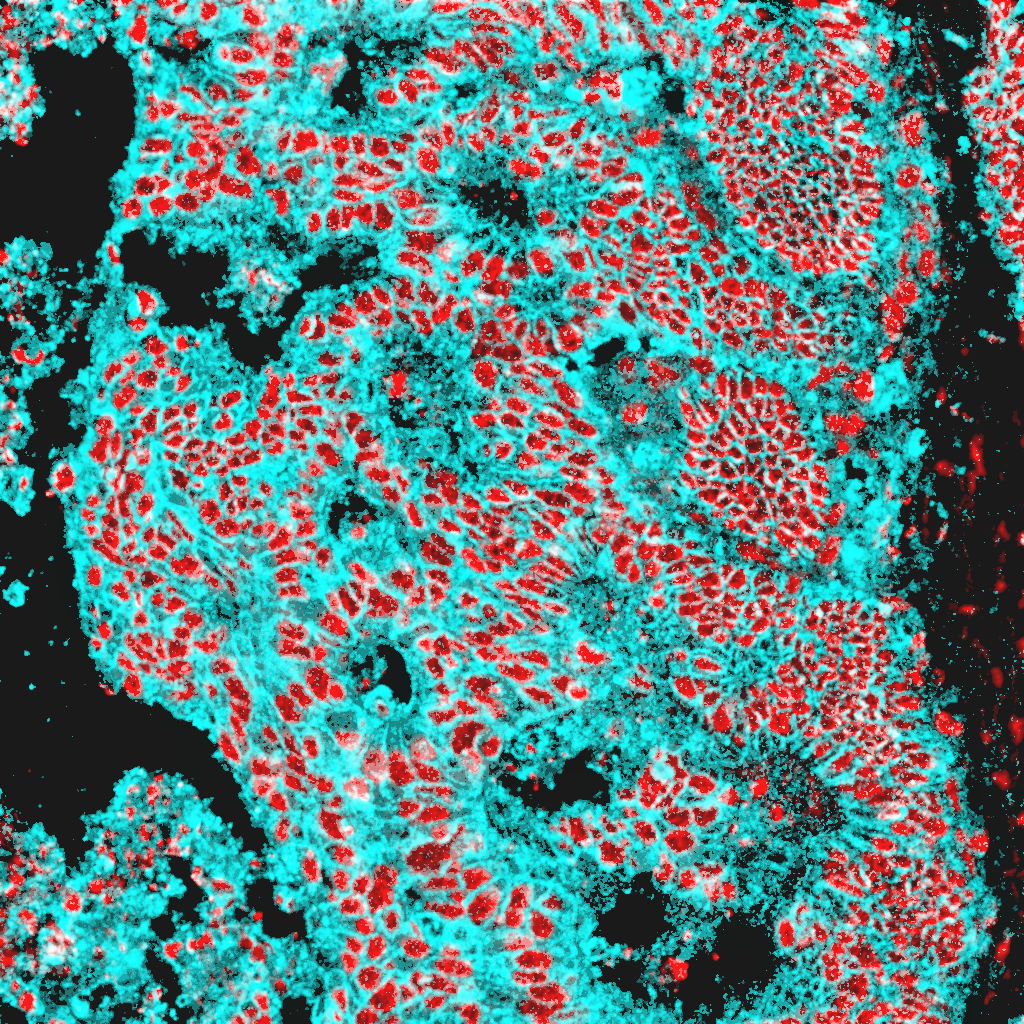

In [41]:
Image.fromarray(rgb)

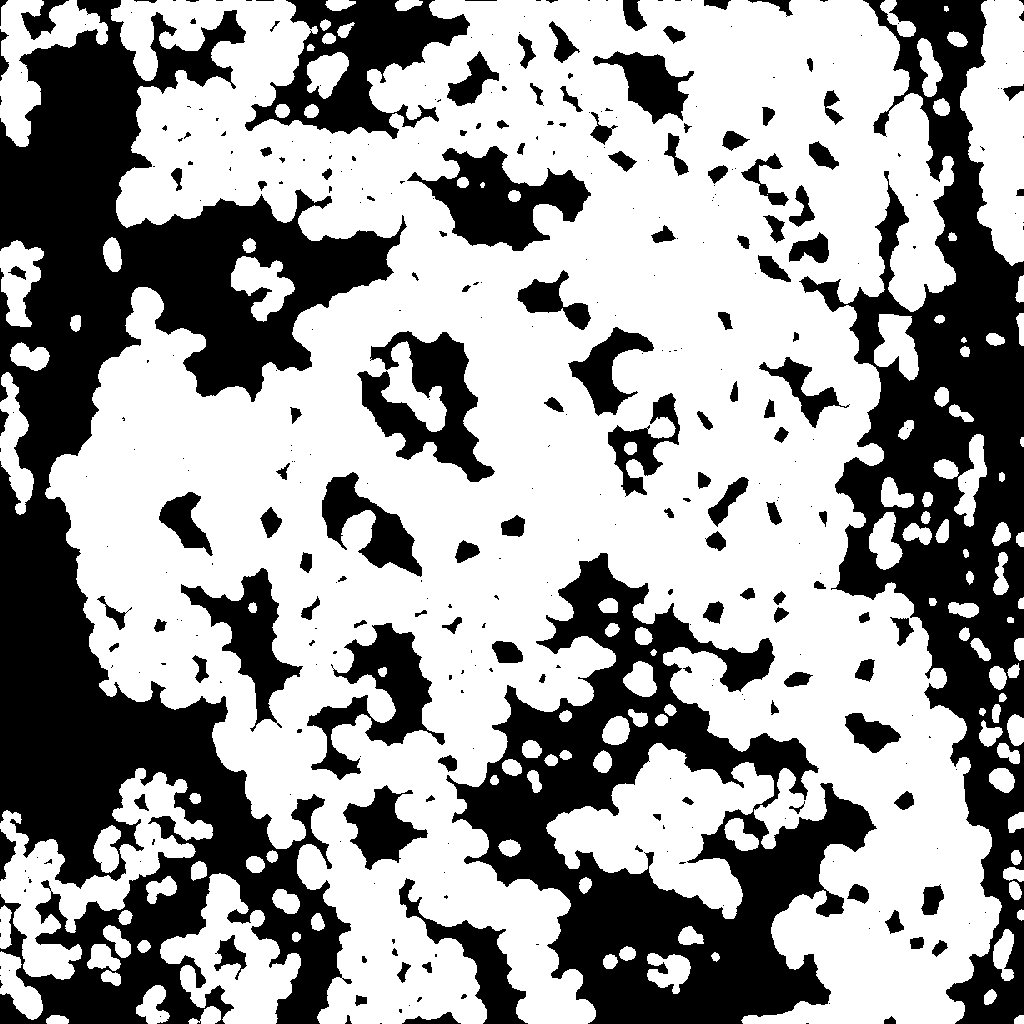

In [53]:
# tissuenet, [3,1]
Image.fromarray(segmentation[0] > 0)

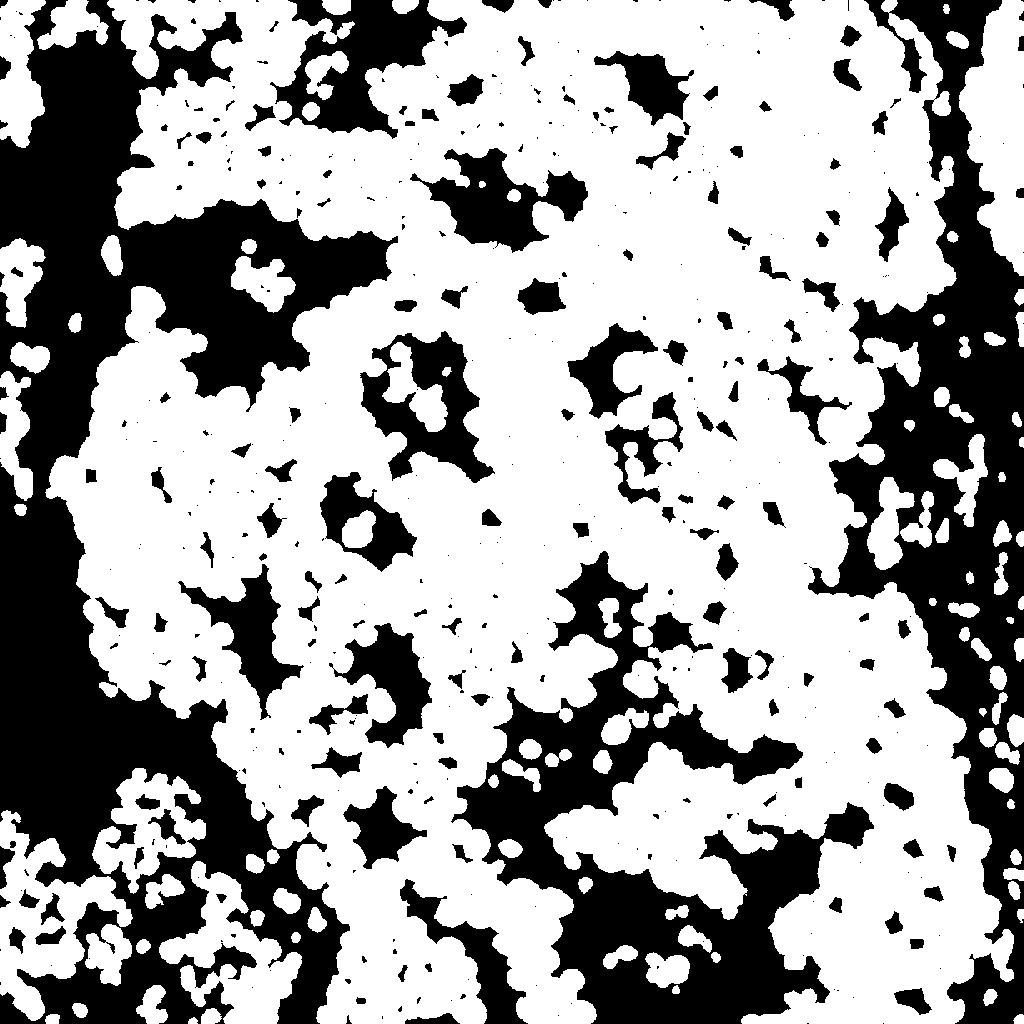

In [50]:
# TN3, [3,1]
Image.fromarray(segmentation[0] > 0)

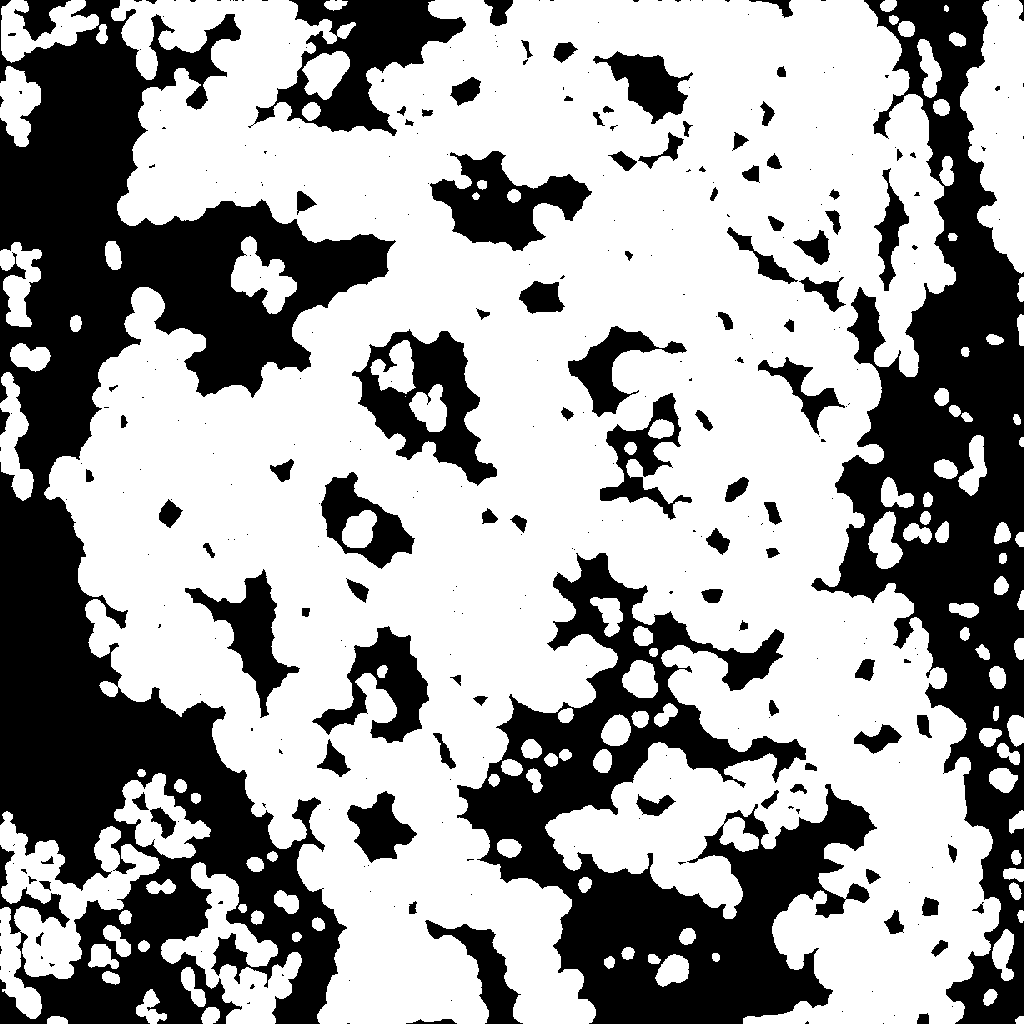

In [44]:
# TN2, [3,1]
Image.fromarray(segmentation[0] > 0)

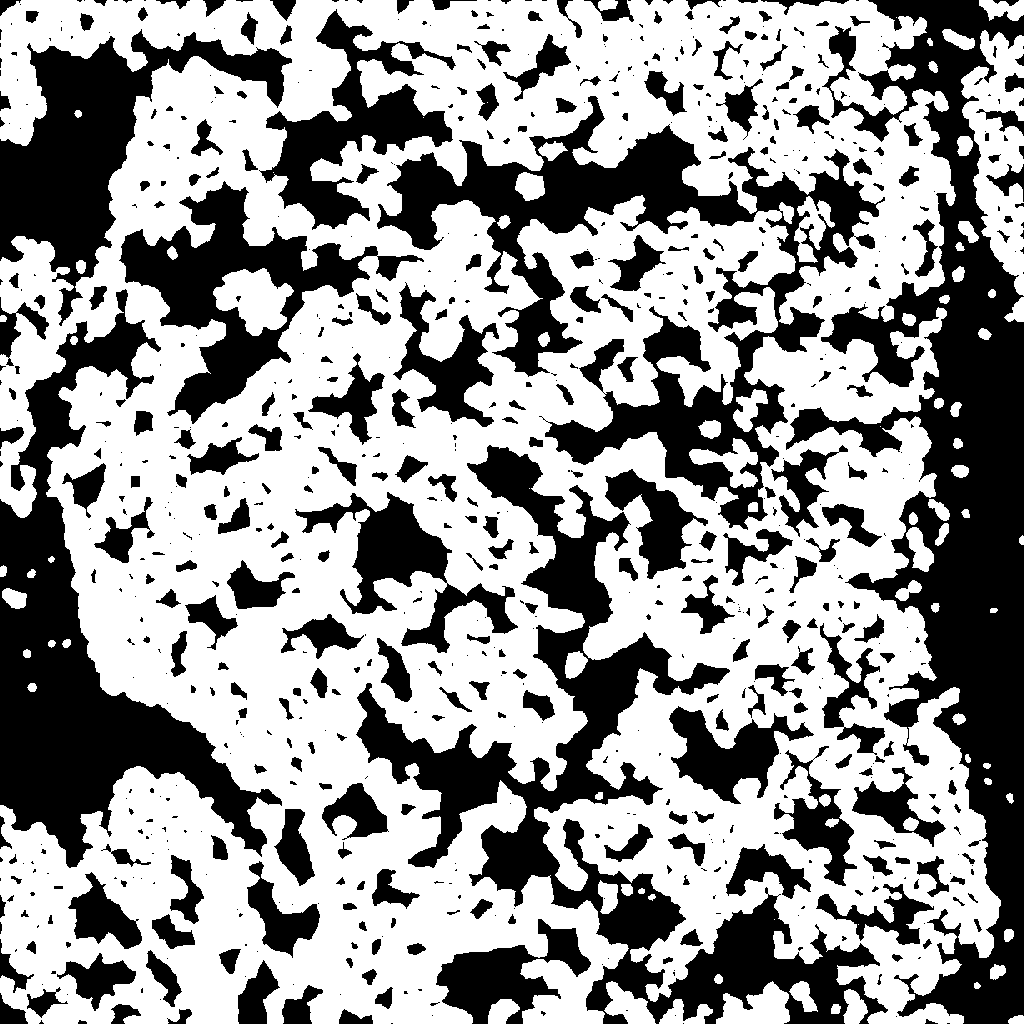

In [42]:
# TN2, [1,3]
Image.fromarray(segmentation[0] > 0)

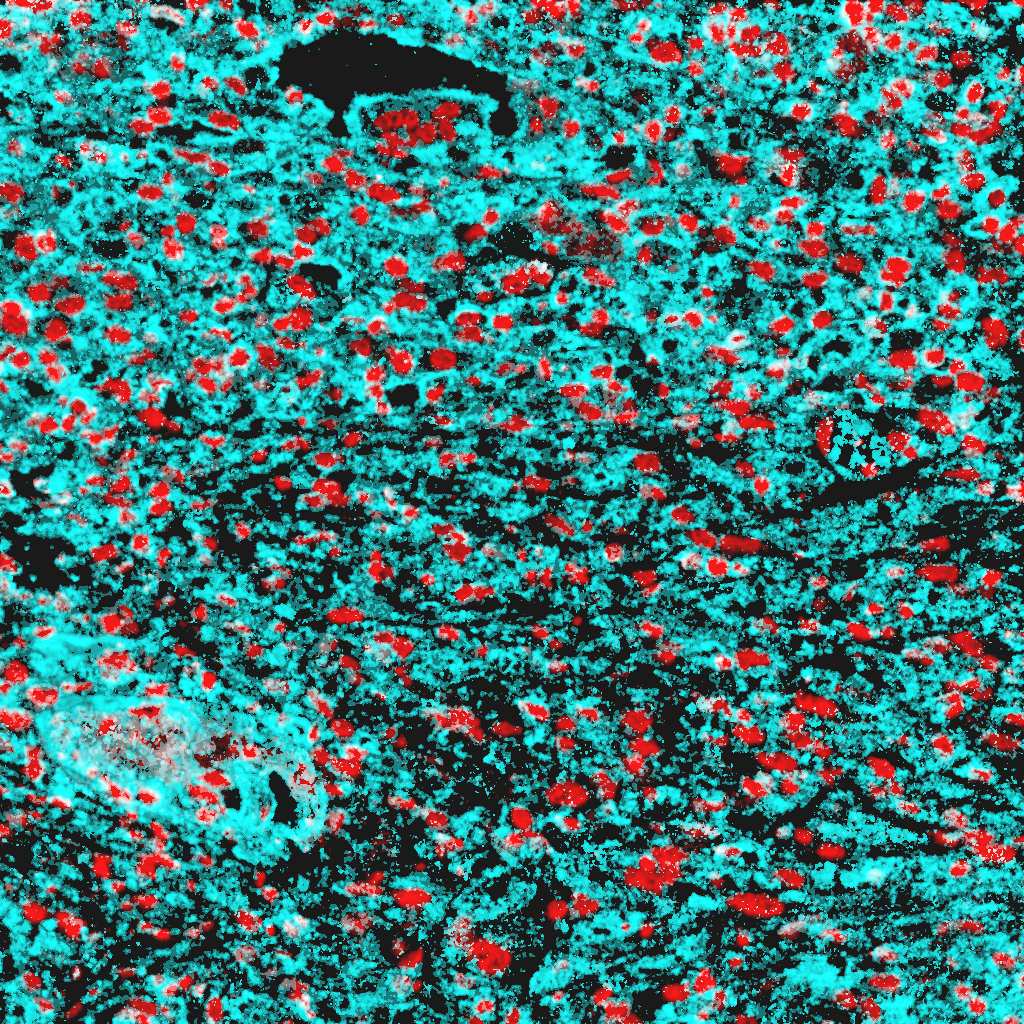

In [37]:
Image.fromarray(rgb)

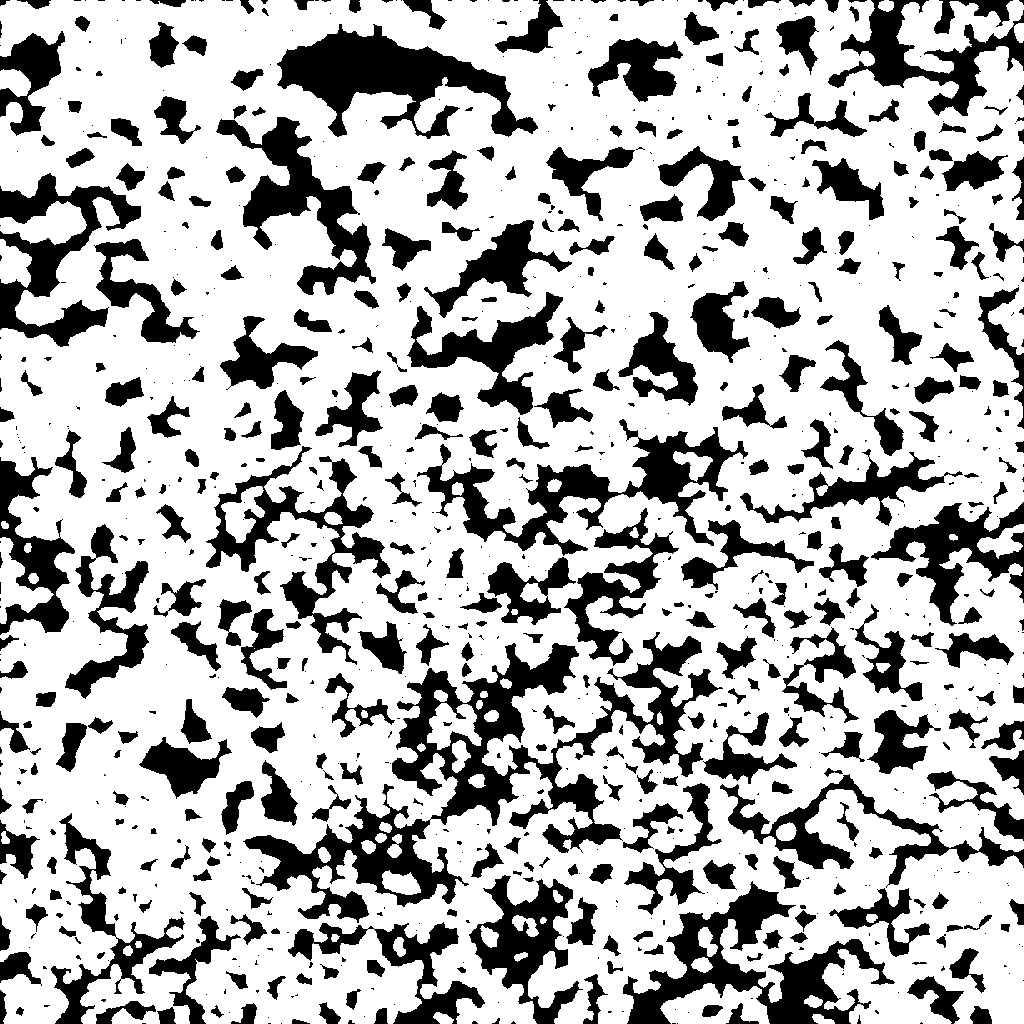

In [36]:
Image.fromarray(segmentation[0] > 0)